In [1]:
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
import math
import pandas as pd
from qiskit_algorithms import Grover,AmplificationProblem
from datetime import datetime
import json, pathlib

In [2]:
try:

    QiskitRuntimeService.save_account(
        channel="ibm_quantum",
        token="7a7db01ab67f2e9082827e16b71b7ca5230d0c4137133a0c9c28a70c96a12bfc92df1005263db0b17d7885549ea8326c9f04f6f3fb409ff08c633ebff8b59561",
        overwrite=True
    )
    service = QiskitRuntimeService(channel="ibm_quantum")
    display(Markdown("## IBM Quantum Authentication Successful"))
except Exception as e:
    display(Markdown(f"## IBM Quantum Authentication Failed: {e}"))
    display(Markdown("Please ensure your IBM Quantum token is correctly set. Hardware execution will be skipped."))
    service = None

## IBM Quantum Authentication Successful

In [3]:
if service:
    backend_name = "ibm_brisbane" 
    try:
        backend = service.backend(name=backend_name)
        status = backend.status()
        config = backend.configuration()
        if not status.operational: 
            raise RuntimeError(f"{backend_name} is not operational.")
        if config.simulator and backend_name != "ibmq_qasm_simulator":
             display(Markdown(f" Selected backend `{backend_name}` is a simulator. "))
        display(Markdown(f"## Backend Selected: {backend.name}"))
        display(Markdown(f"* Status: {'Operational' if status.operational else 'Not Operational'}"))
        display(Markdown(f"* Qubit Count: {config.n_qubits}"))
        display(Markdown(f"* Pending Jobs: {status.pending_jobs}"))
    except Exception as e:
        display(Markdown(f"## Could not get backend `{backend_name}`: {e}"))
        display(Markdown("Hardware execution will be skipped."))
        backend = None
else:
    backend = None

## Backend Selected: ibm_brisbane

* Status: Operational

* Qubit Count: 127

* Pending Jobs: 4

In [4]:
def construct_oracle(marked_state: str) -> QuantumCircuit:
    n = len(marked_state)
    # Use a named QuantumRegister
    qr = QuantumRegister(n, name='q') 
    oracle = QuantumCircuit(qr) # Initialize with the named QuantumRegister
    
    # Apply operations using qubits from the register
    for i, bit in enumerate(marked_state):
        if bit == '0':
            oracle.x(qr[i])
            
    if n == 1:
        oracle.z(qr[0])
    elif n == 2:
        oracle.cz(qr[0], qr[1])
    else:
        oracle.h(qr[n-1])
        # Ensure mcx uses the Qubit objects from the register
        control_qubits = [qr[j] for j in range(n-1)]
        target_qubit = qr[n-1]
        oracle.mcx(control_qubits, target_qubit)
        oracle.h(qr[n-1])
        
    for i, bit in enumerate(marked_state):
        if bit == '0':
            oracle.x(qr[i])
            
    return oracle


In [5]:
n = 3 
all_states = [format(i, f'0{n}b') for i in range(2**n)]
k_iterations = math.floor(math.pi/4 * math.sqrt(2**n))

In [6]:
sim = AerSimulator()
logical_circuits = []             
sim_results      = {}
metrics          = {} 

---
### Standard Qiskit-Grover circuit for |000⟩ (with measurements)

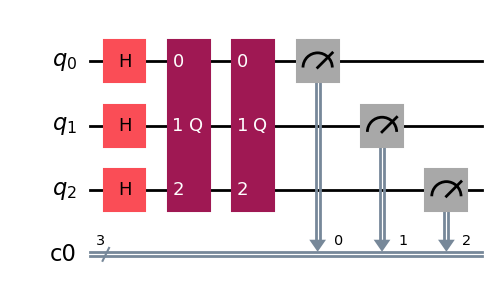

**Simulator results for |000⟩:** `{'110': 3, '100': 11, '001': 11, '101': 7, '000': 958, '010': 9, '111': 9, '011': 16}`

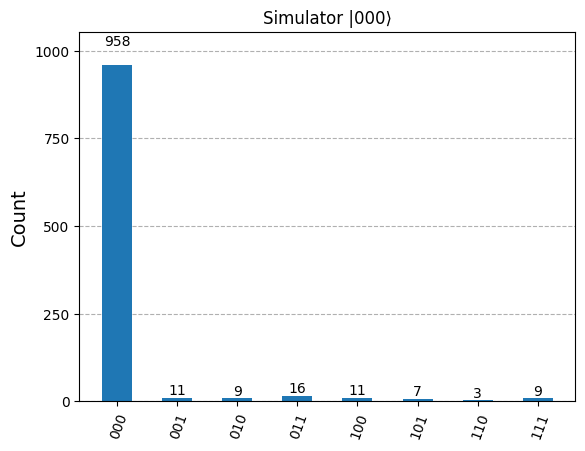

---
### Standard Qiskit-Grover circuit for |001⟩ (with measurements)

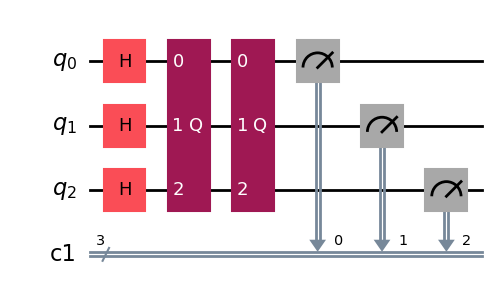

**Simulator results for |001⟩:** `{'101': 8, '000': 7, '010': 13, '001': 965, '100': 5, '110': 7, '011': 8, '111': 11}`

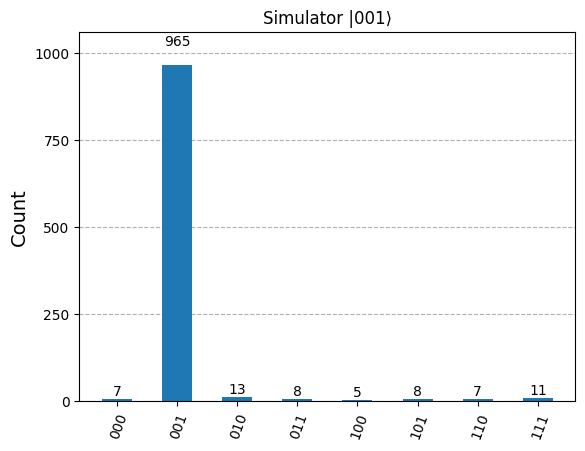

---
### Standard Qiskit-Grover circuit for |010⟩ (with measurements)

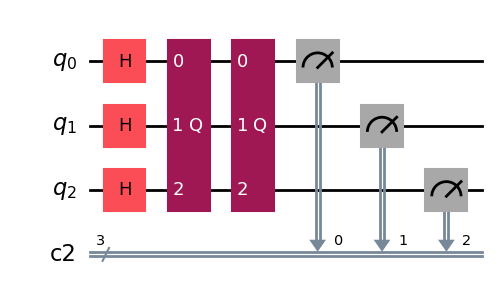

**Simulator results for |010⟩:** `{'011': 5, '111': 7, '110': 12, '001': 6, '100': 8, '101': 7, '000': 6, '010': 973}`

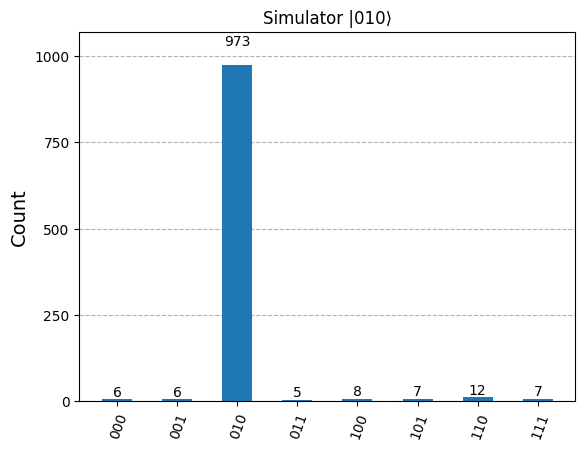

---
### Standard Qiskit-Grover circuit for |011⟩ (with measurements)

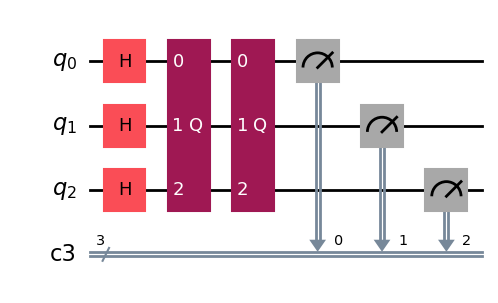

**Simulator results for |011⟩:** `{'011': 965, '111': 5, '100': 9, '001': 9, '110': 6, '101': 10, '000': 12, '010': 8}`

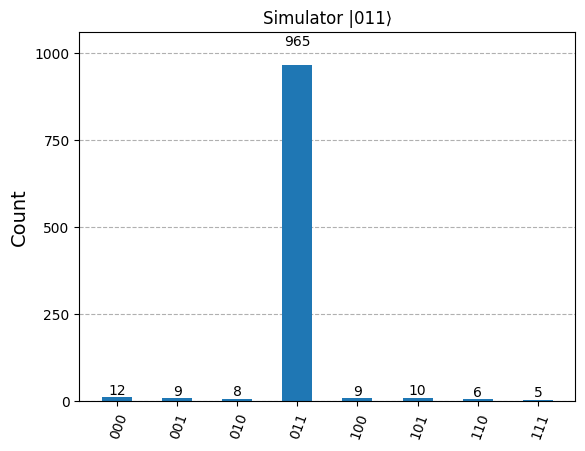

---
### Standard Qiskit-Grover circuit for |100⟩ (with measurements)

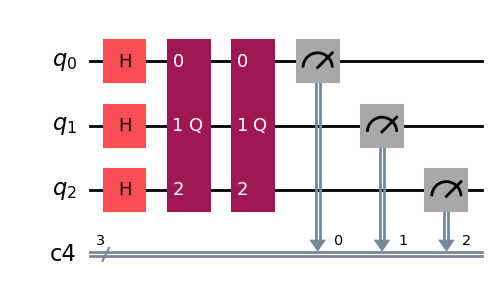

**Simulator results for |100⟩:** `{'011': 7, '111': 3, '101': 10, '001': 5, '100': 969, '110': 11, '000': 10, '010': 9}`

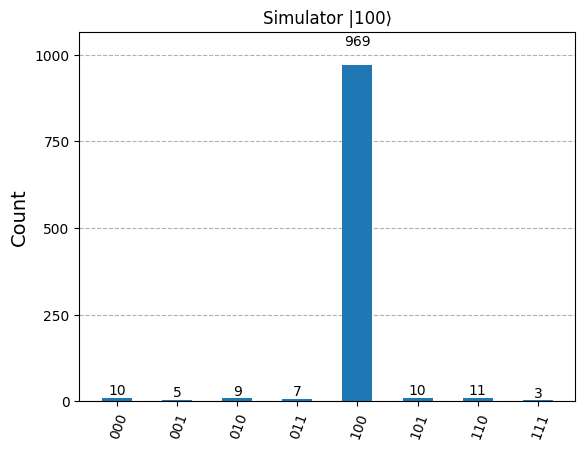

---
### Standard Qiskit-Grover circuit for |101⟩ (with measurements)

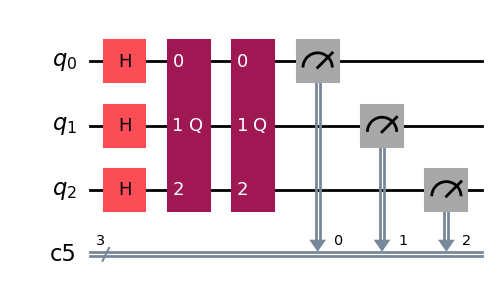

**Simulator results for |101⟩:** `{'000': 10, '010': 8, '011': 6, '111': 13, '001': 12, '100': 13, '110': 8, '101': 954}`

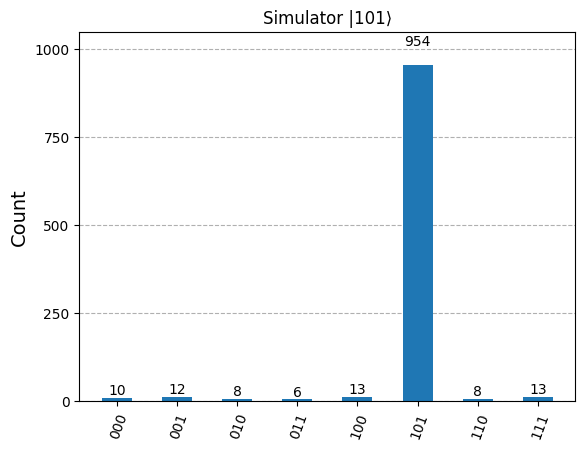

---
### Standard Qiskit-Grover circuit for |110⟩ (with measurements)

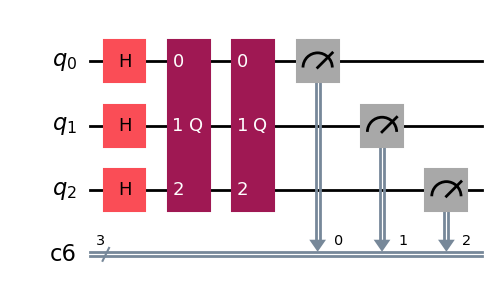

**Simulator results for |110⟩:** `{'001': 12, '110': 969, '100': 6, '000': 7, '010': 5, '101': 6, '111': 8, '011': 11}`

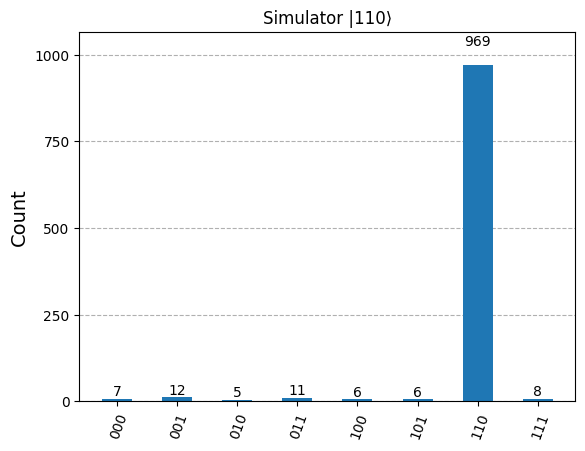

---
### Standard Qiskit-Grover circuit for |111⟩ (with measurements)

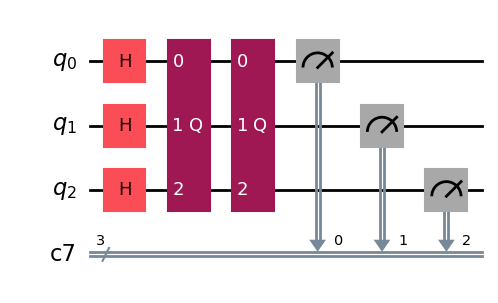

**Simulator results for |111⟩:** `{'101': 9, '100': 6, '110': 14, '001': 9, '000': 7, '010': 5, '011': 6, '111': 968}`

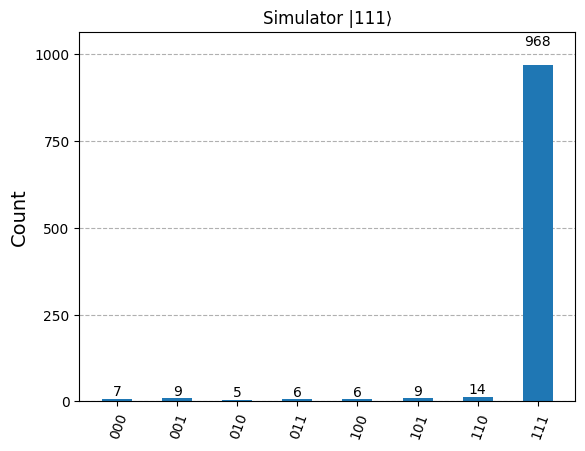

In [7]:
for raw_state in all_states:
    rev_state = raw_state[::-1]

    # 1) Build the oracle (now returns a circuit with a named QuantumRegister 'q')
    oracle = construct_oracle(rev_state)

    # 2) Use Qiskit’s Grover primitive
    problem = AmplificationProblem(
        oracle=oracle,
        is_good_state=lambda bitstr: bitstr == rev_state
    )
    grover_algo = Grover(iterations=k_iterations)
    # MODIFIED: Instruct Grover to construct the circuit WITH measurements.
    # This will add a ClassicalRegister (typically named 'meas' or 'c') and measure all qubits to it.
    qc = grover_algo.construct_circuit(problem, measurement=True)

    # 3) Metrics on the logical circuit (qc is now already measured by Grover)
    ops        = qc.count_ops()
    gate_count = sum(ops.values())
    cx_count   = ops.get('cx', 0)
    depth      = qc.depth()
    metrics[raw_state] = {
        "gate_count_raw": gate_count,
        "cx_count_raw":   cx_count,
        "depth_raw":      depth
    }

    # 4) Store for later hardware transpile (qc now includes named QR, CR, and measurements)
    logical_circuits.append((raw_state, qc))

    # 5) Display and simulate (qc is already measured)
    display(Markdown(f"---\n### Standard Qiskit-Grover circuit for |{raw_state}⟩ (with measurements)"))
    display(qc.draw("mpl", idle_wires=False)) # idle_wires=False is good practice

    qc_sim = transpile(qc, sim) # Transpile the already measured qc for the simulator
    job    = sim.run(qc_sim, shots=1024).result()
    counts = job.get_counts() # get_counts() will use the classical register Grover added
    sim_results[raw_state] = counts

    display(Markdown(f"**Simulator results for |{raw_state}⟩:** `{counts}`"))
    display(plot_histogram(counts, title=f"Simulator |{raw_state}⟩"))

**Transpiled circuit |000⟩ on ibm_brisbane:**

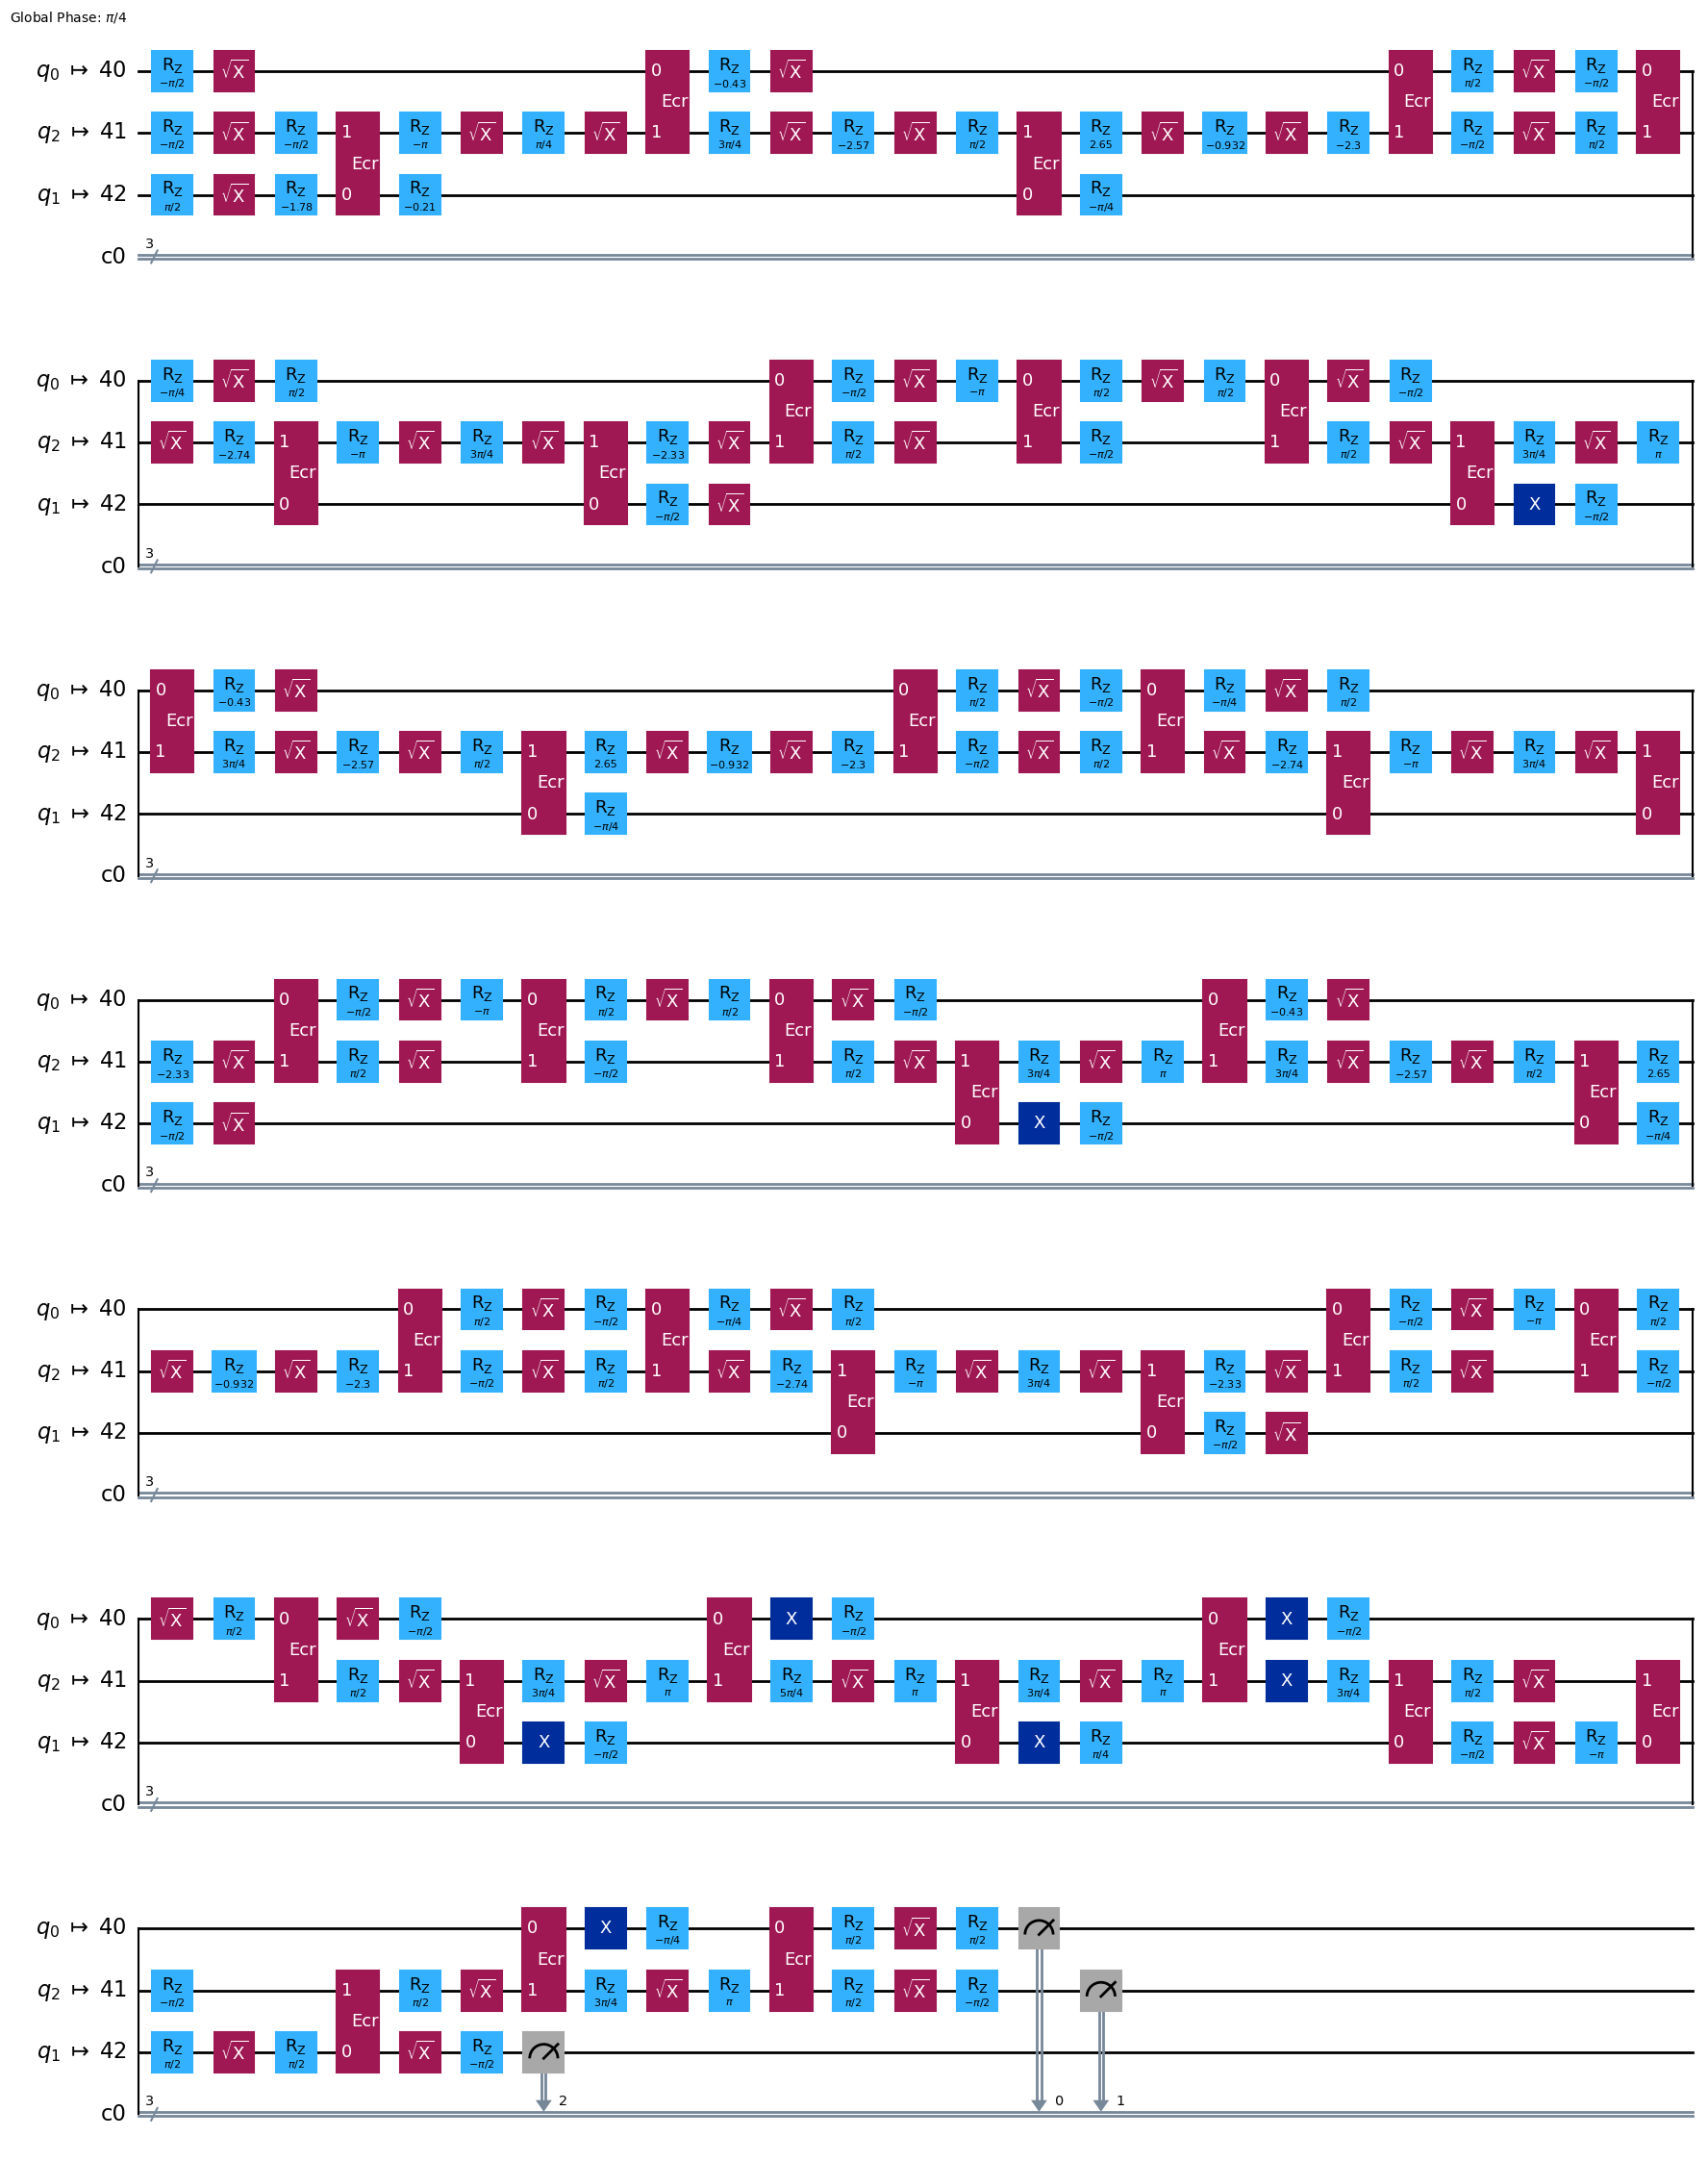

**Transpiled circuit |001⟩ on ibm_brisbane:**

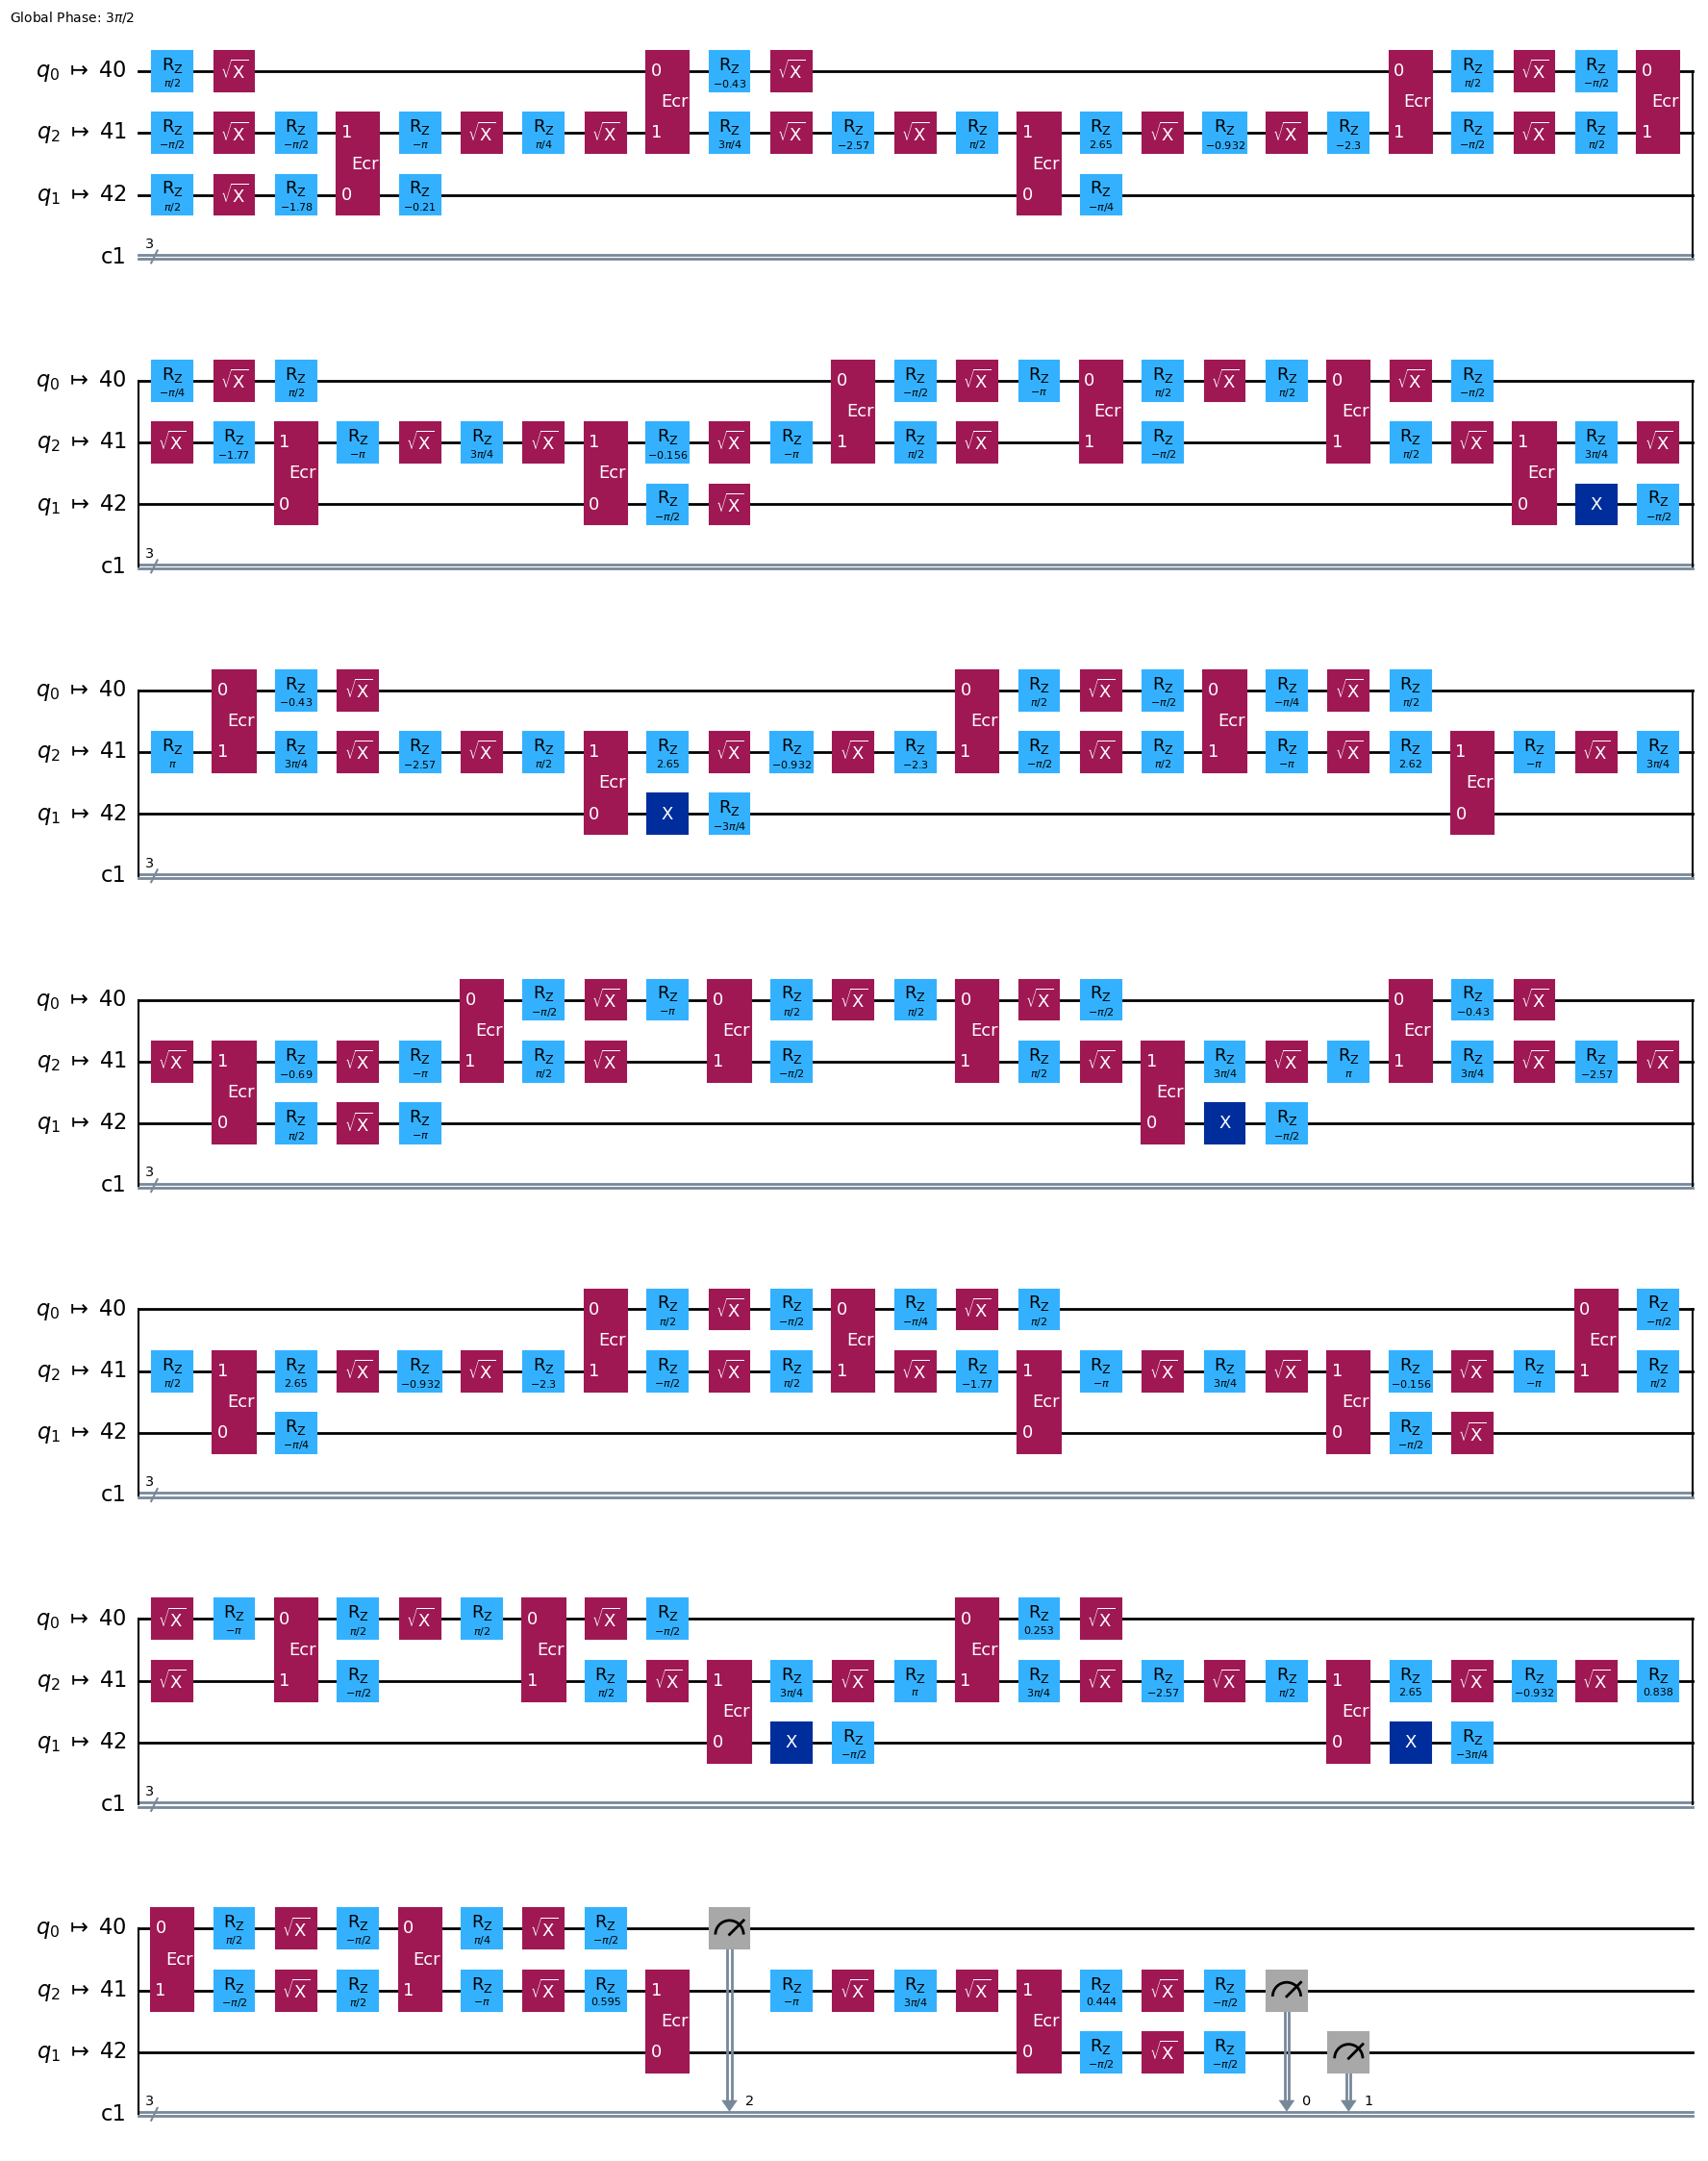

**Transpiled circuit |010⟩ on ibm_brisbane:**

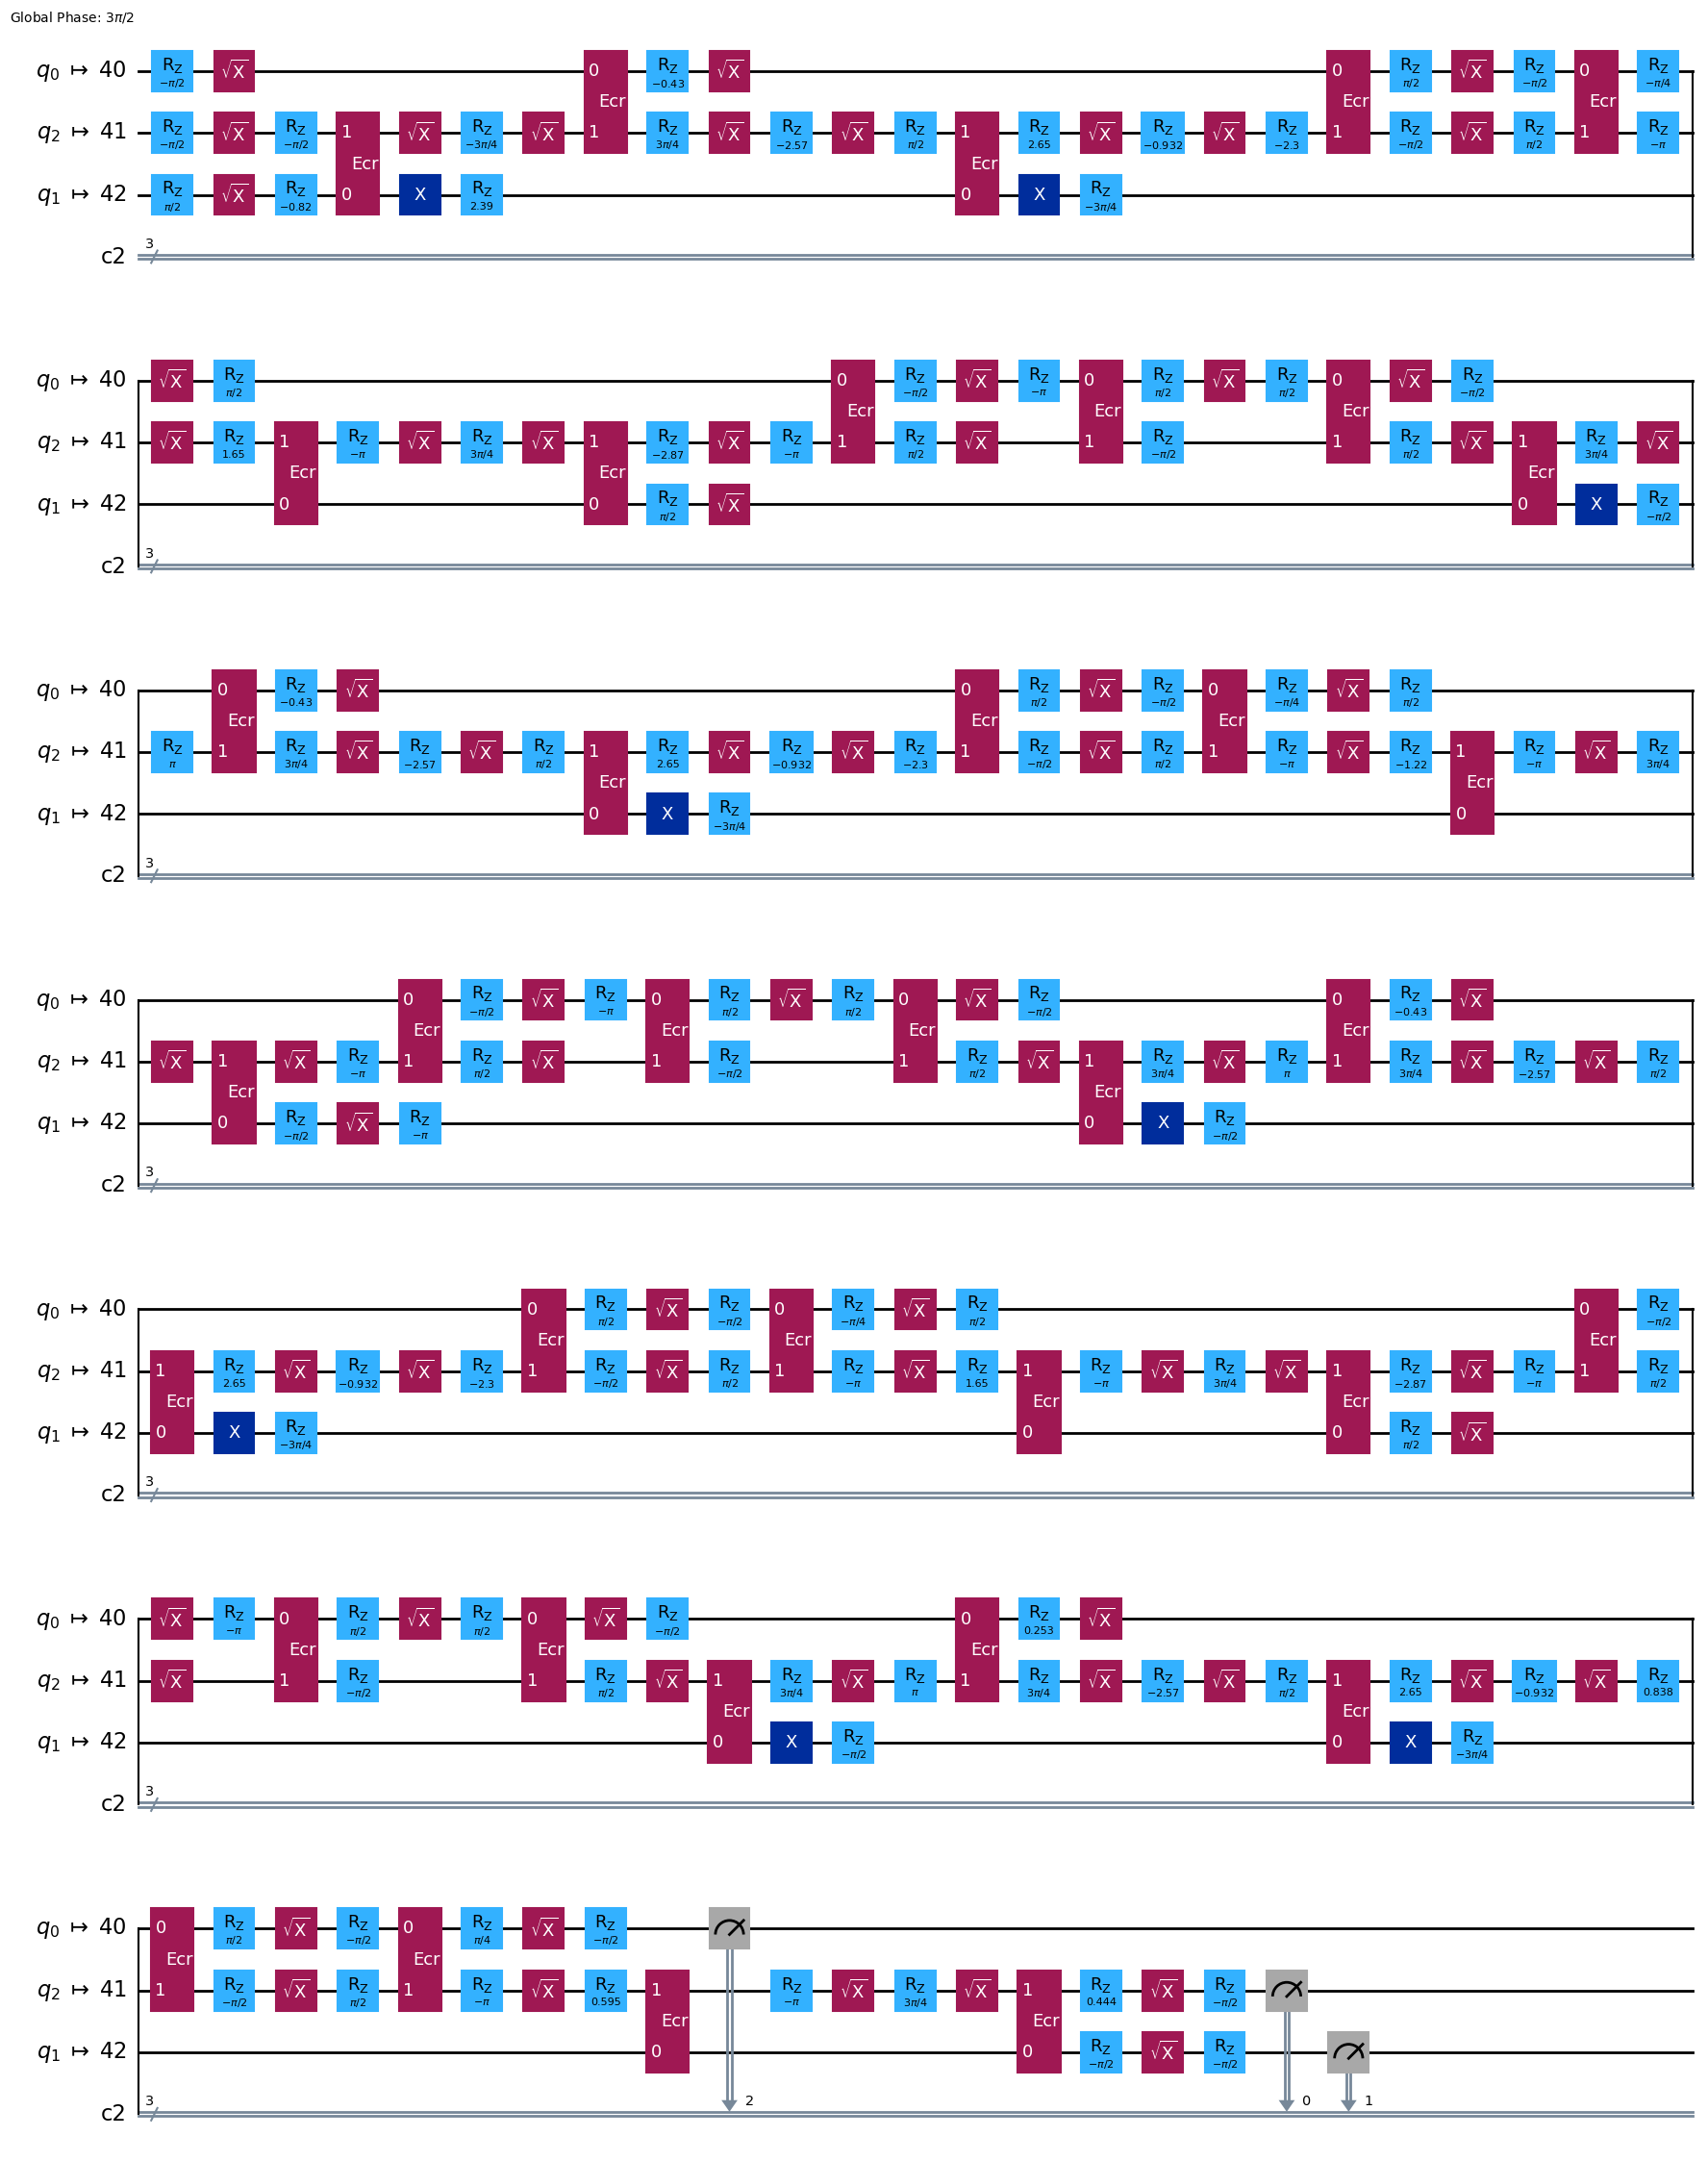

**Transpiled circuit |011⟩ on ibm_brisbane:**

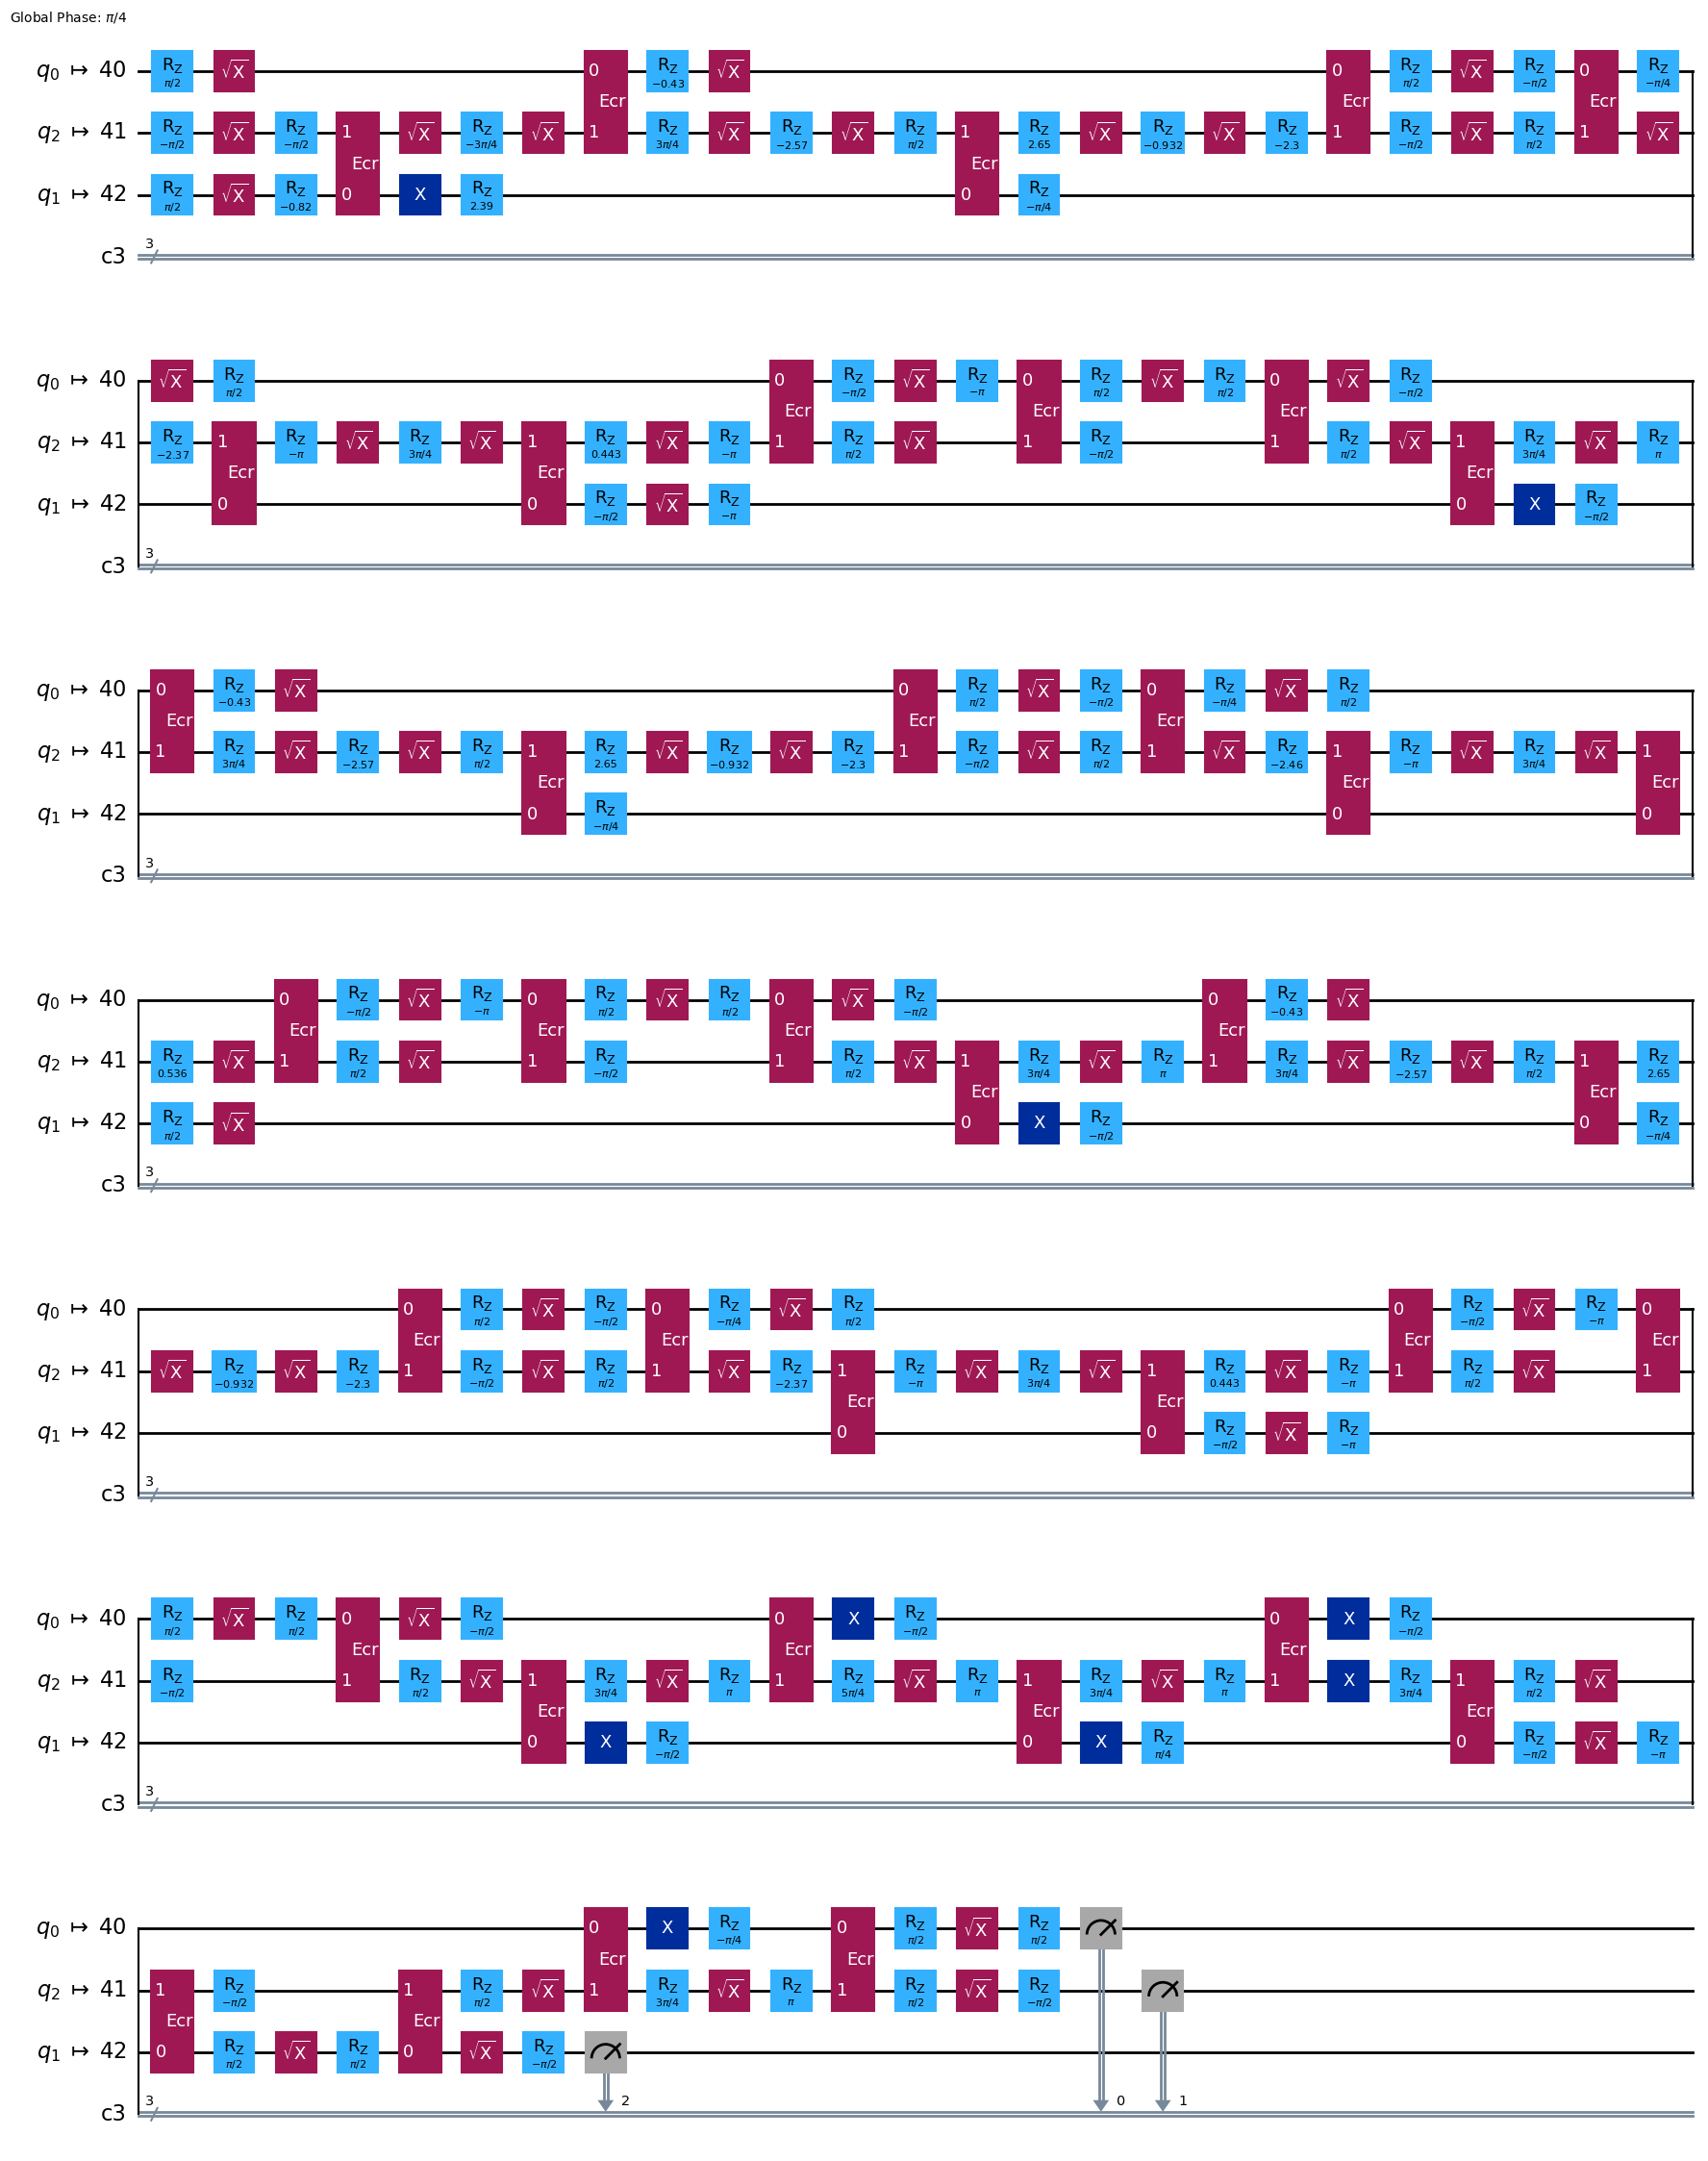

**Transpiled circuit |100⟩ on ibm_brisbane:**

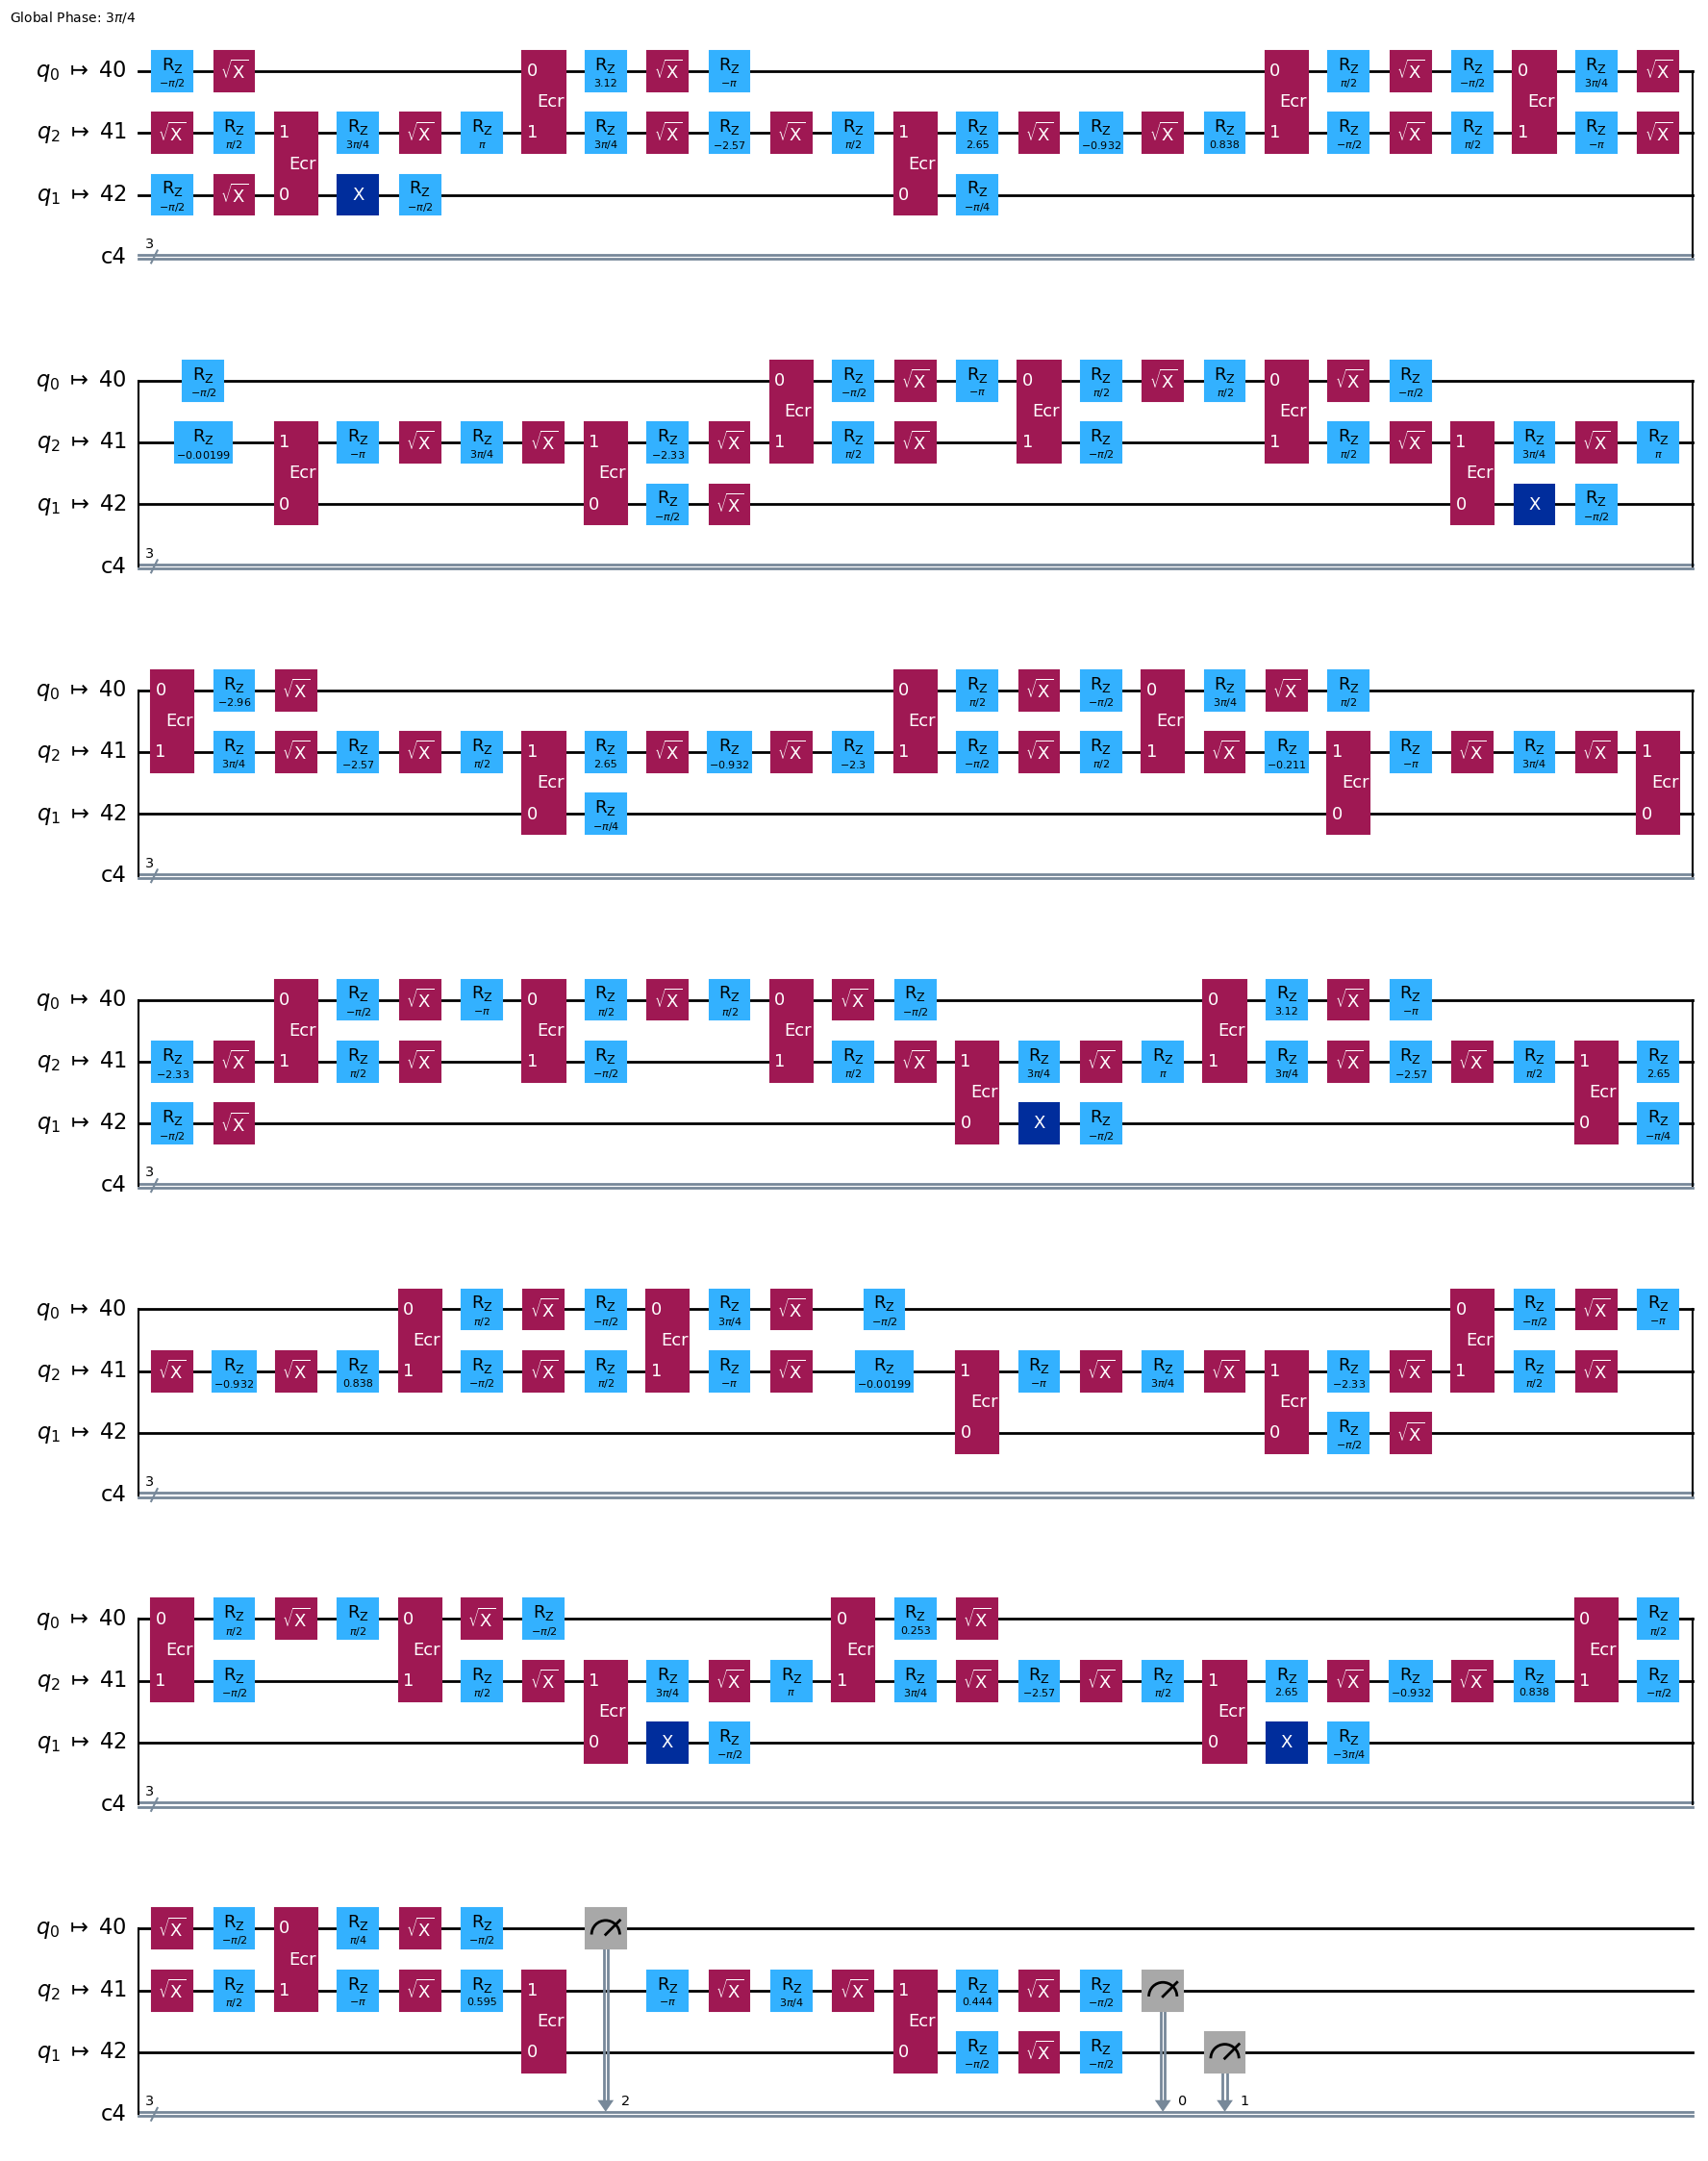

**Transpiled circuit |101⟩ on ibm_brisbane:**

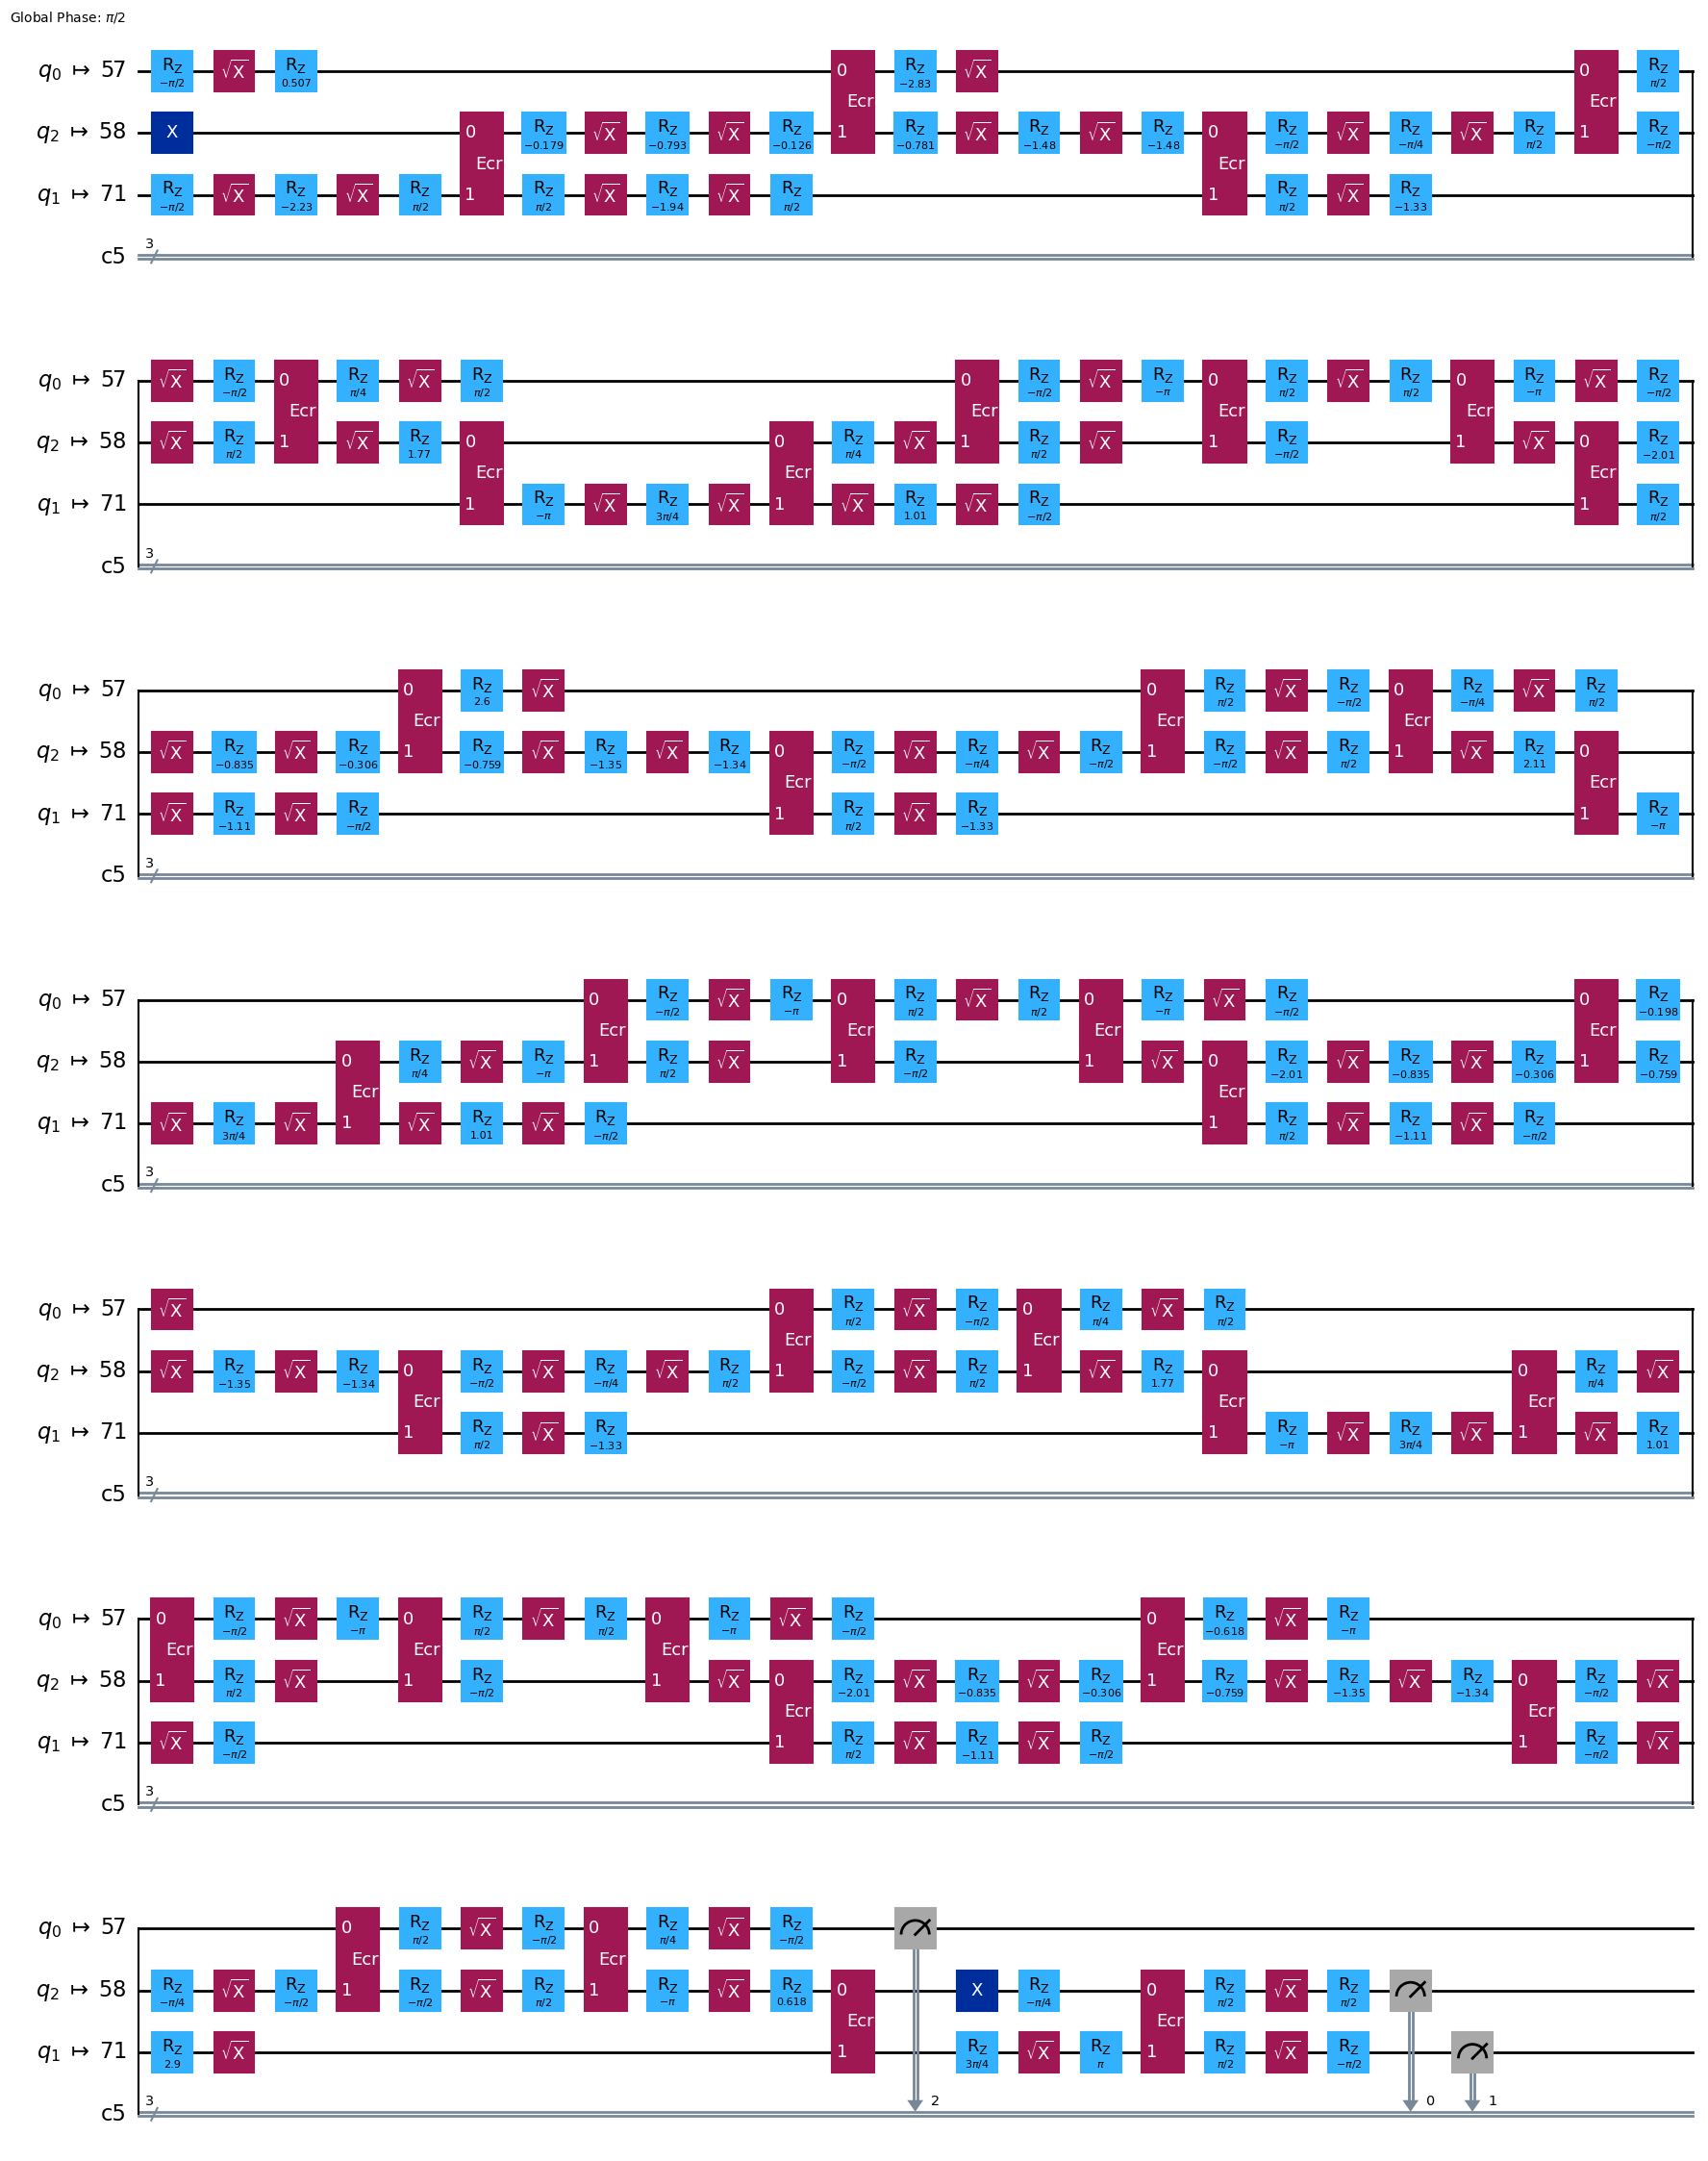

**Transpiled circuit |110⟩ on ibm_brisbane:**

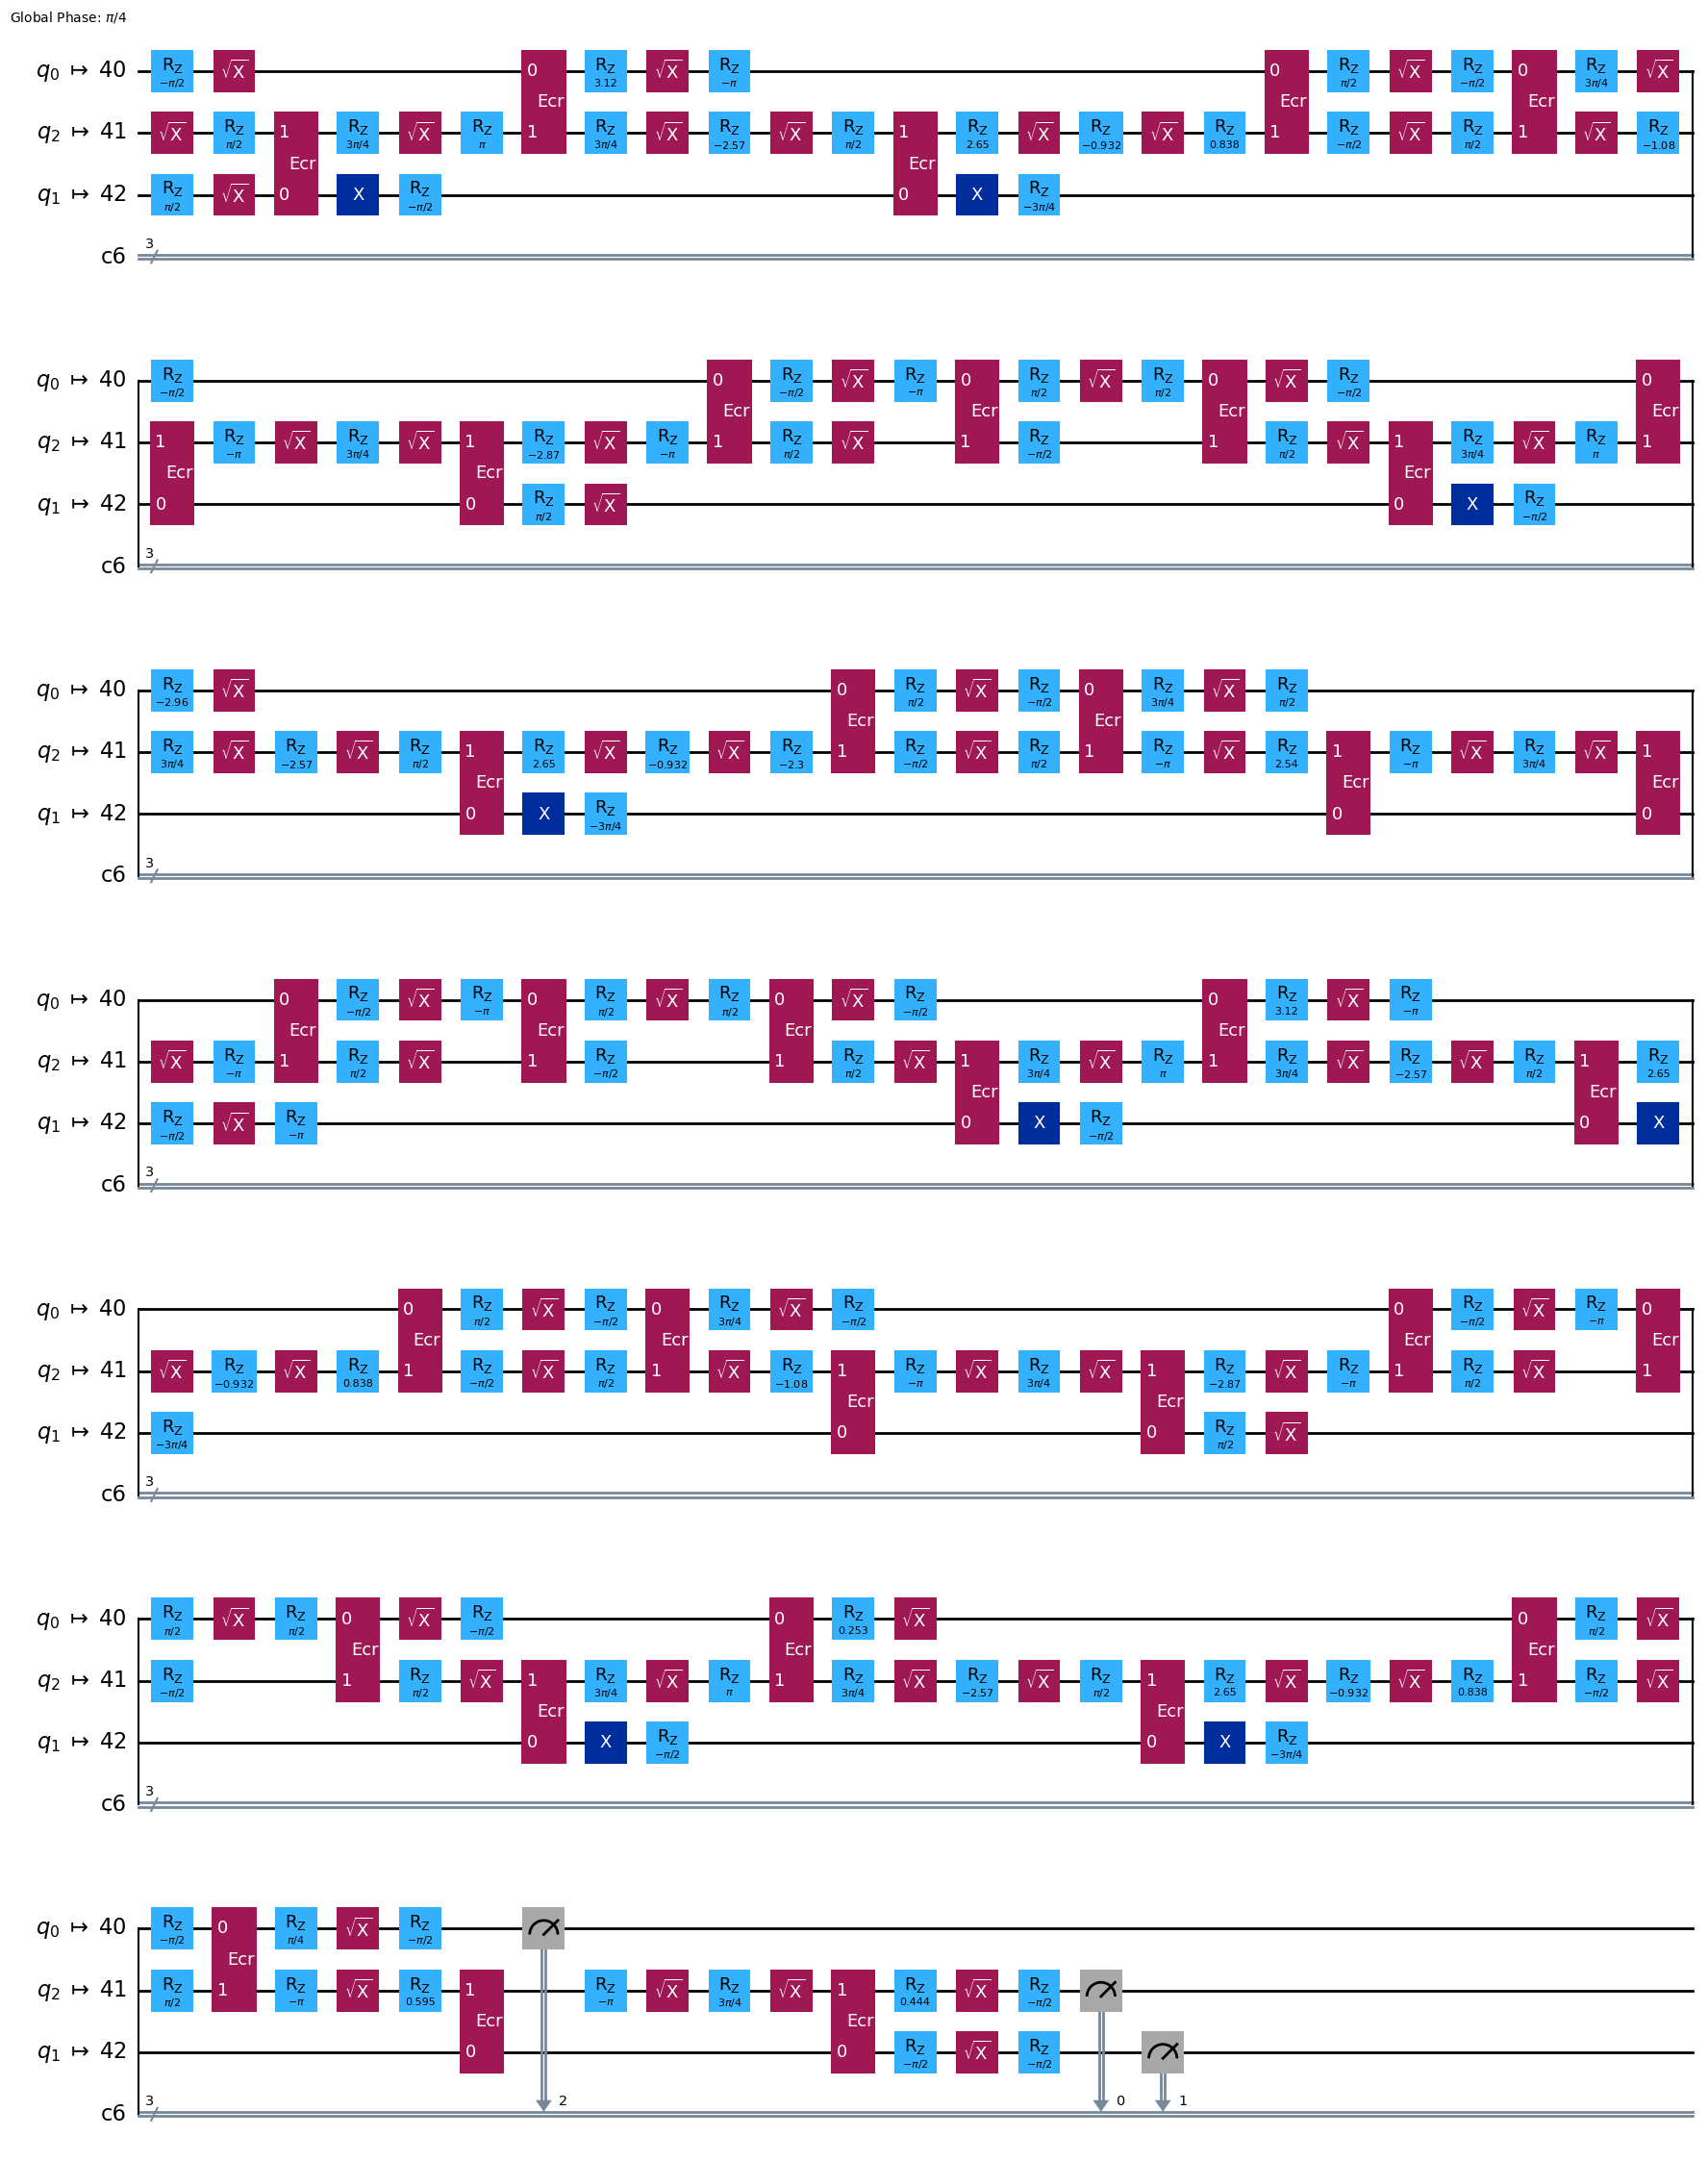

**Transpiled circuit |111⟩ on ibm_brisbane:**

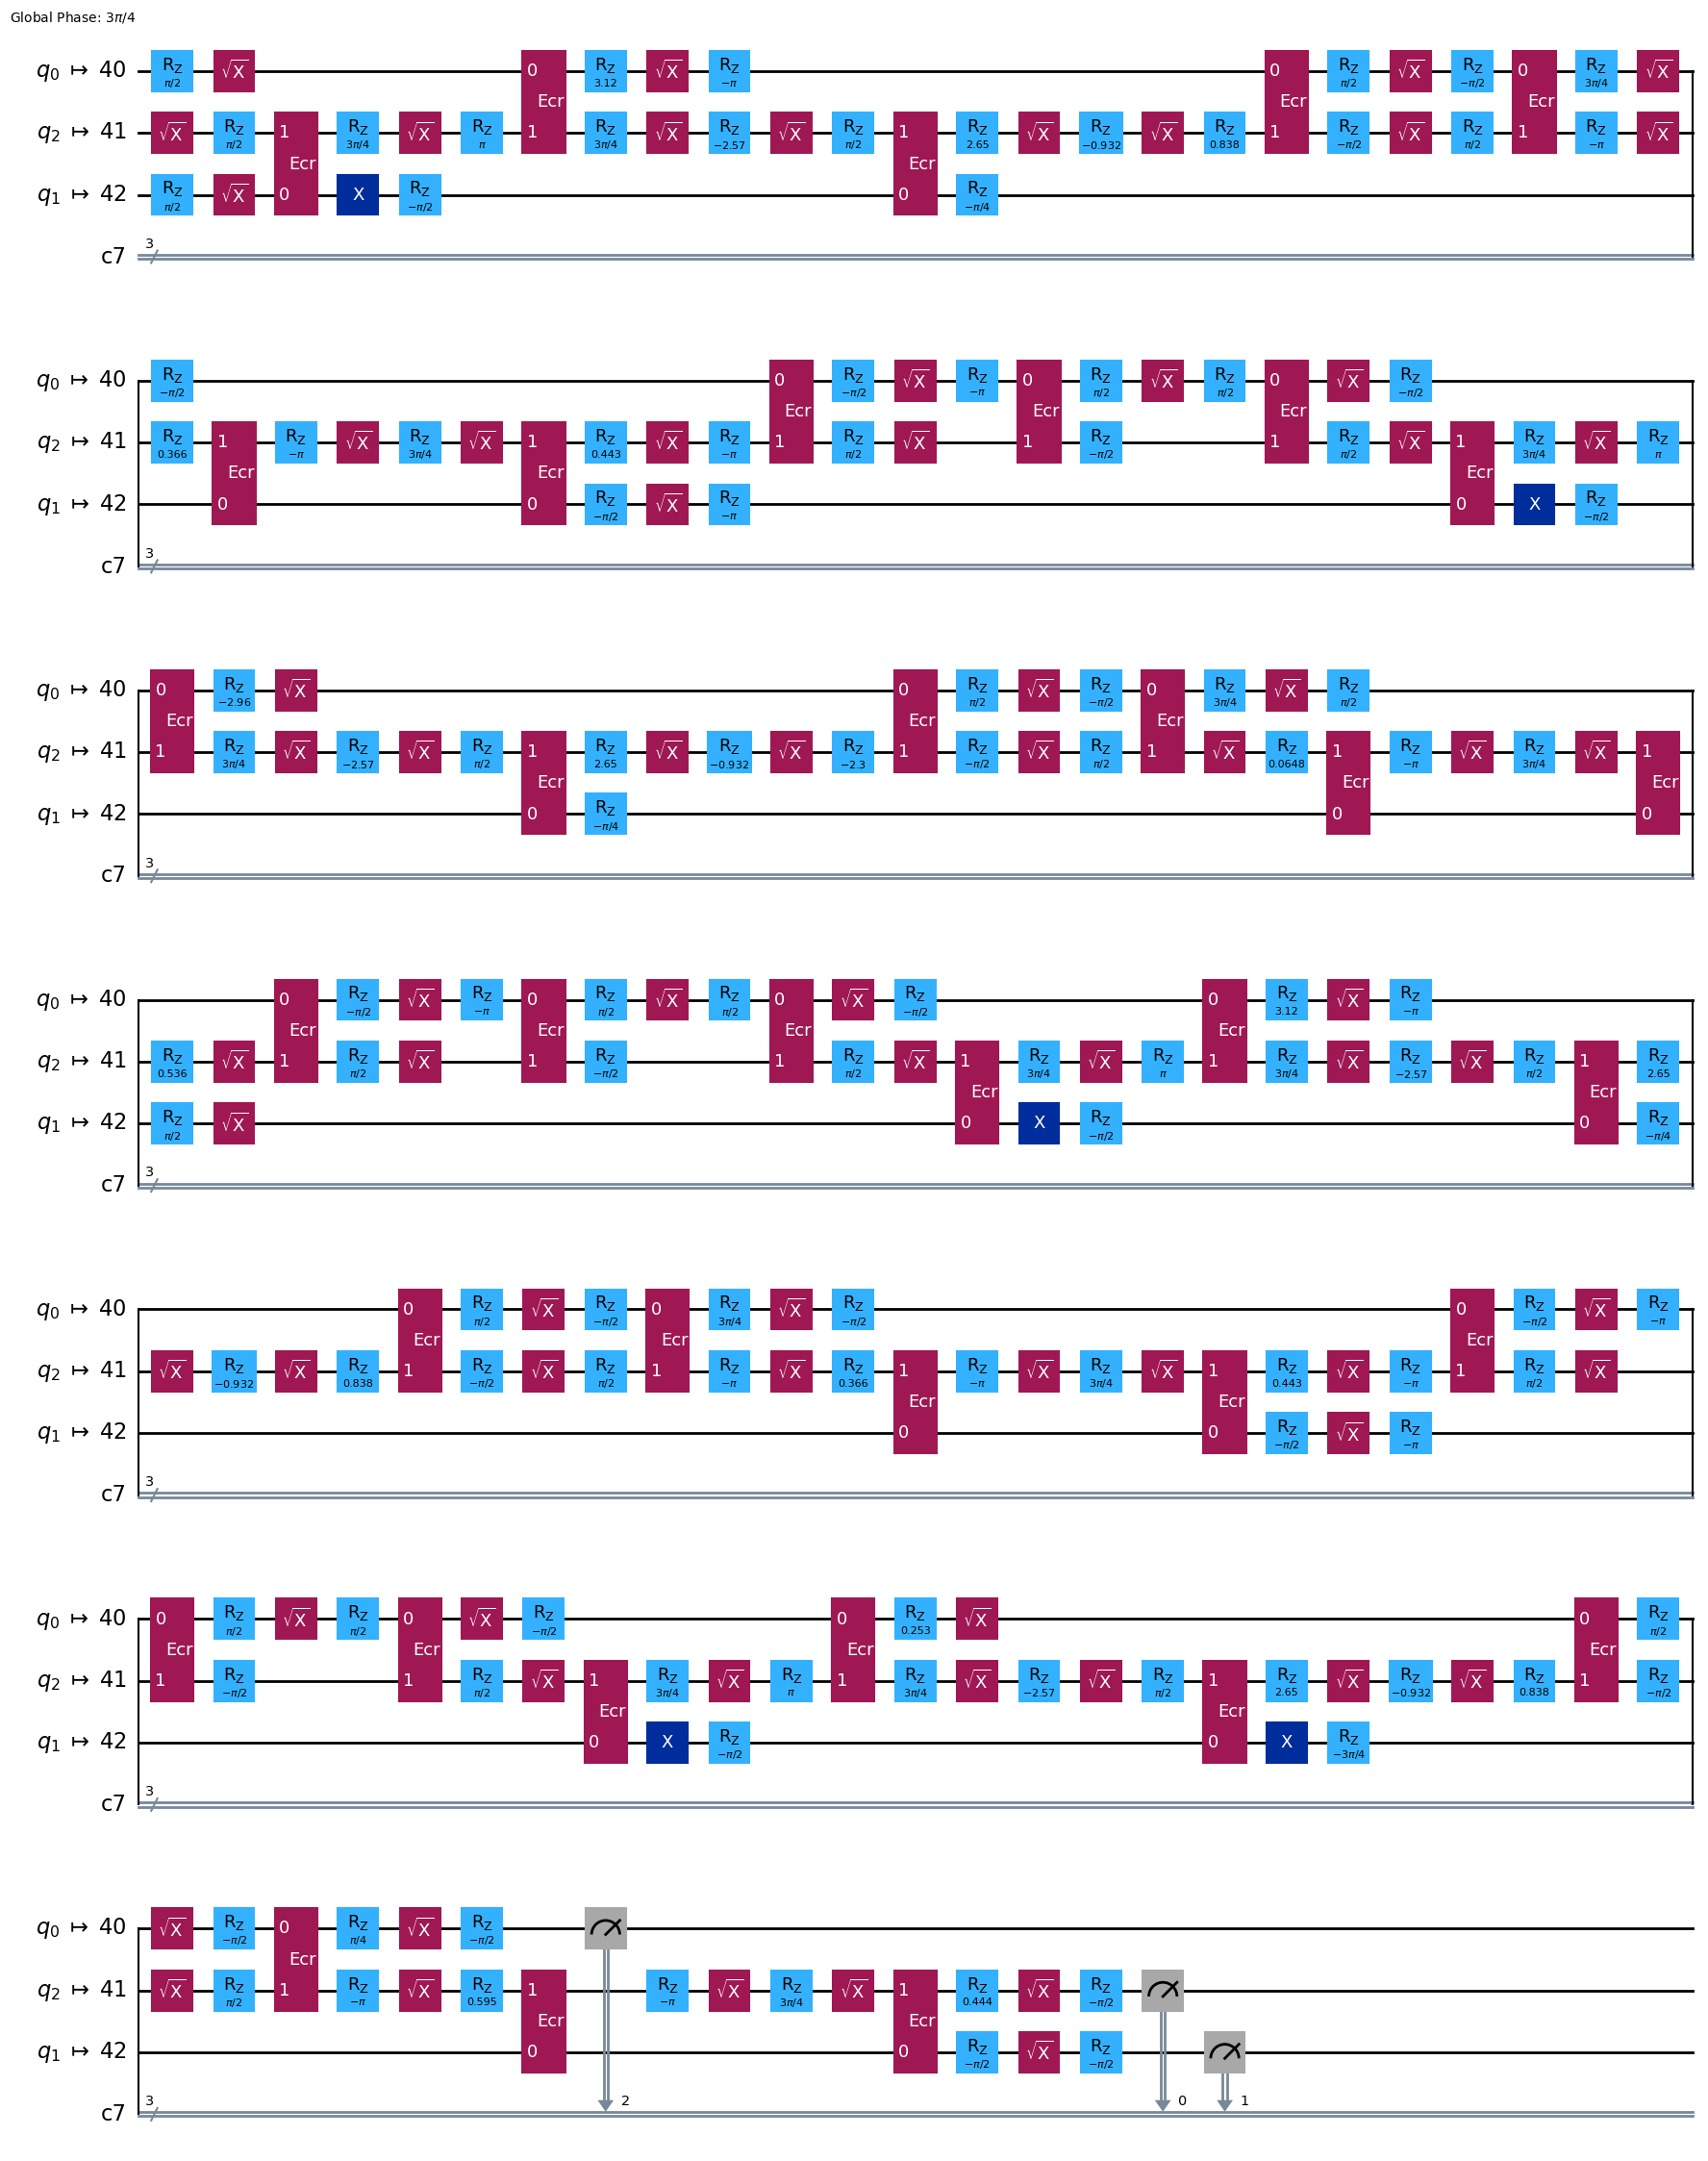

In [8]:
pm = generate_preset_pass_manager(target=backend.target, optimization_level=3)
hw_circuits = []
for state, qc in logical_circuits:
    # --- 1  Transpile to Brisbane’s native gate set  -----------------
    qc_isa = pm.run(qc)
    hw_circuits.append((state, qc_isa))

    display(Markdown(f"**Transpiled circuit |{state}⟩ on {backend.name}:**"))
    display(qc_isa.draw(output="mpl", idle_wires=False))

    # --- 2  *NEW*: collect ISA-level metrics and merge into the same row ----
    isa_ops        = qc_isa.count_ops()
    metrics[state].update(
        gate_count_isa = sum(isa_ops.values()),
        cx_count_isa   = isa_ops.get('cx', 0),
        depth_isa      = qc_isa.depth()
    )

In [9]:
sampler = Sampler(backend=backend)             
sampler.options.default_shots = 1024     

/var/folders/rc/j294rj094lb9j6zz6fcghj7m0000gn/T/ipykernel_11105/30260975.py:1: DeprecationWarning: The 'backend' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  sampler = Sampler(backend=backend)


Calibration saved → calibrations/ibm_brisbane_2025-05-27T14:29:09+01:00.json


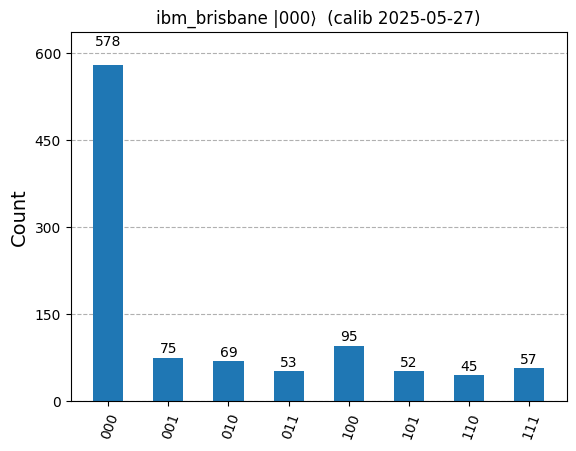

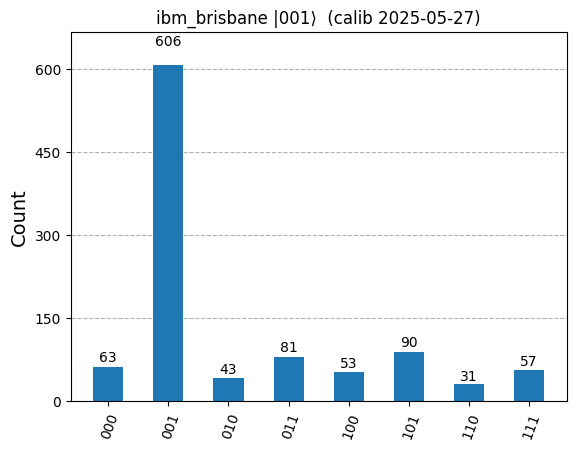

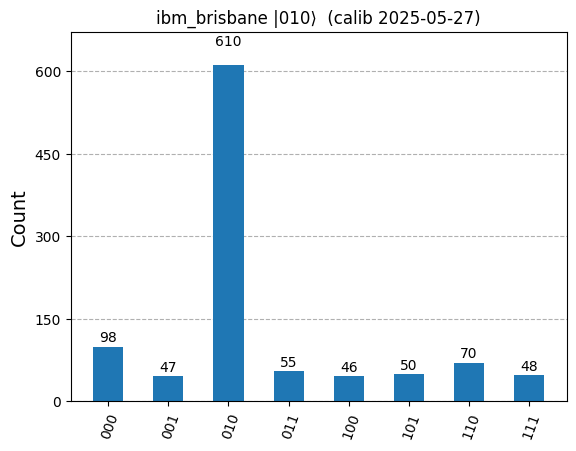

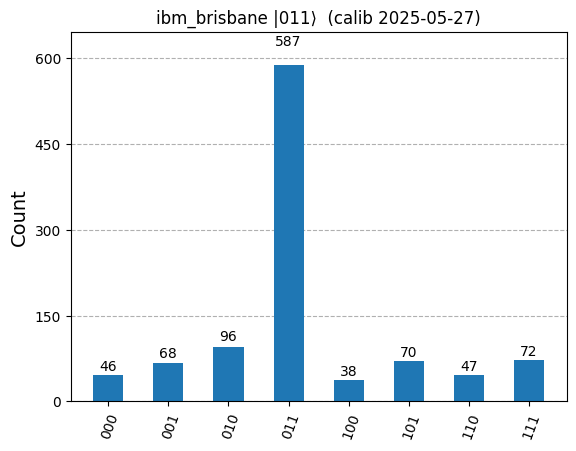

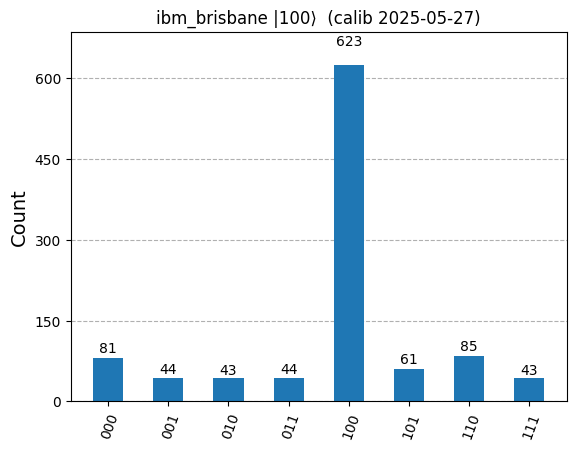

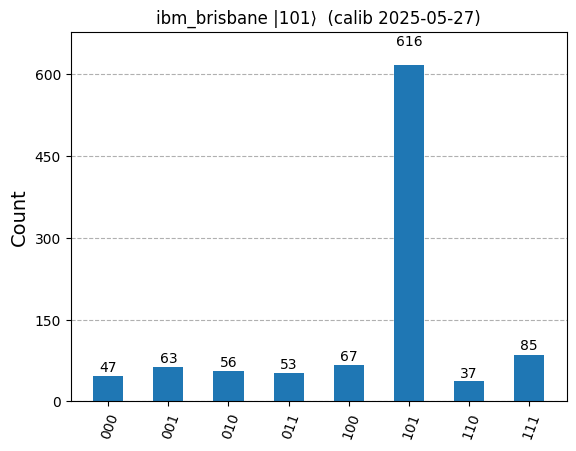

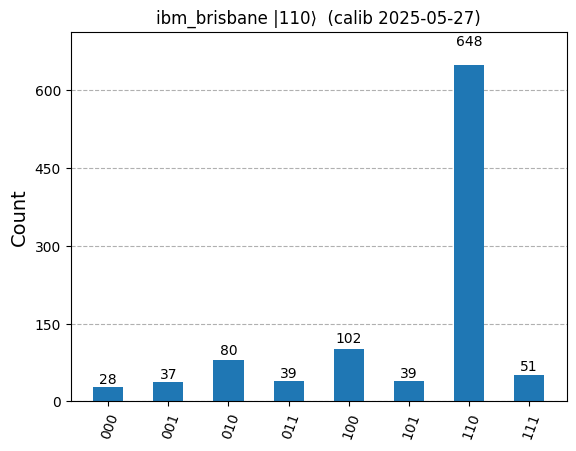

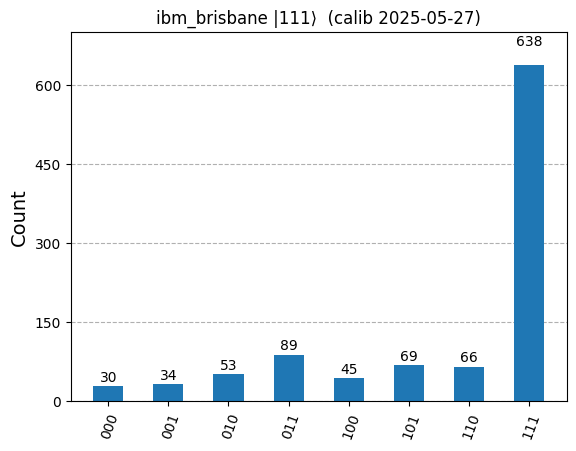

In [11]:
# --- A  snapshot the calibration BEFORE you queue anything ----------
calib   = backend.properties()          # PropertiesV2 object
calib_ts = calib.last_update_date.isoformat()  # human-readable
calib_dict = calib.to_dict()            # pure-Python dict, JSON-serialisable

# save to ./calibrations/brisbane_2025-05-27T12-34-56.json
calib_dir = pathlib.Path("calibrations")
calib_dir.mkdir(exist_ok=True)
calib_file = calib_dir / f"{backend.name}_{calib_ts}.json"
with calib_file.open("w") as fp:
    json.dump(calib_dict, fp, indent=2, default=str)
print(f"Calibration saved → {calib_file}")

# --- B  batch-submit all ISA circuits -------------------------------
circuits_to_run = [qc for _, qc in hw_circuits]   # just the circuits
job       = sampler.run(circuits_to_run, shots=1024)
result    = job.result()                          # ← single queue wait

# --- C  extract counts & plot --------------------------------------
for idx, (state, _) in enumerate(hw_circuits):
    pubres = result[idx]                          # SamplerPubResult
    counts = pubres.join_data().get_counts()

    # keep a record if you wish
    metrics[state]["counts_hw"] = counts

    display(plot_histogram(counts,
             title=f"{backend.name} |{state}⟩  (calib {calib_ts[:10]})"))


Running Grover for |000⟩ on ibm_brisbane…


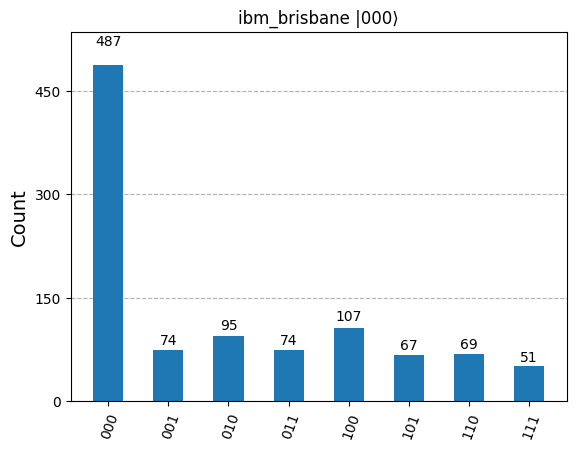


Running Grover for |001⟩ on ibm_brisbane…


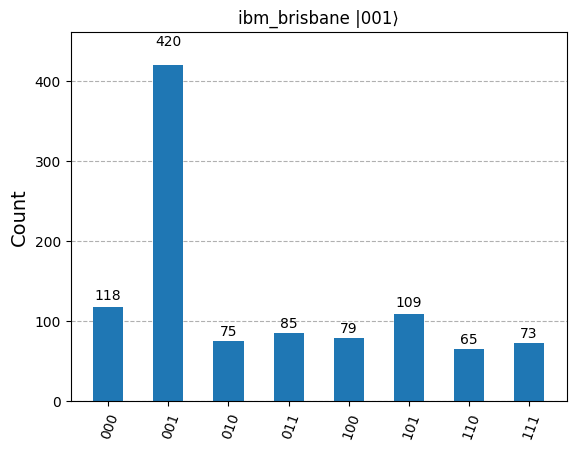


Running Grover for |010⟩ on ibm_brisbane…


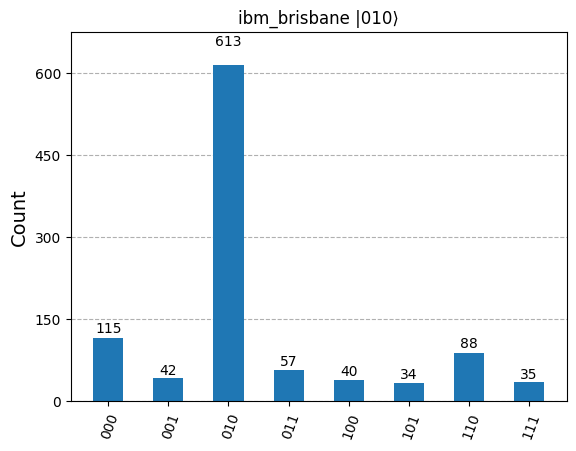


Running Grover for |011⟩ on ibm_brisbane…


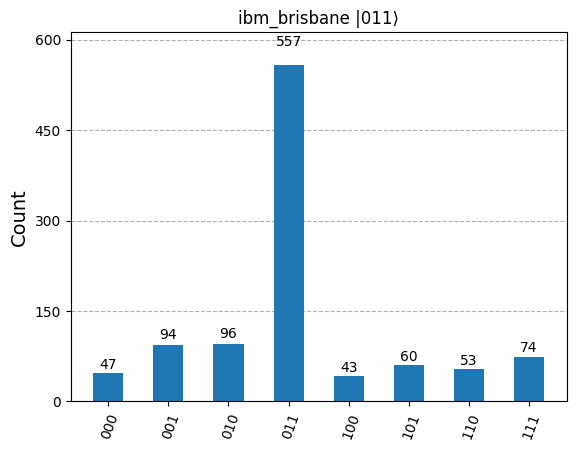


Running Grover for |100⟩ on ibm_brisbane…


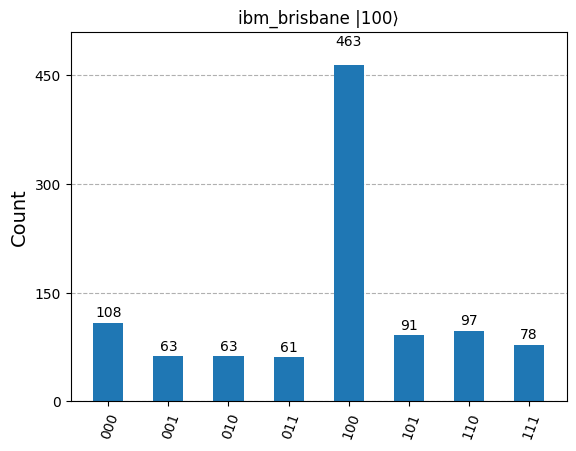


Running Grover for |101⟩ on ibm_brisbane…


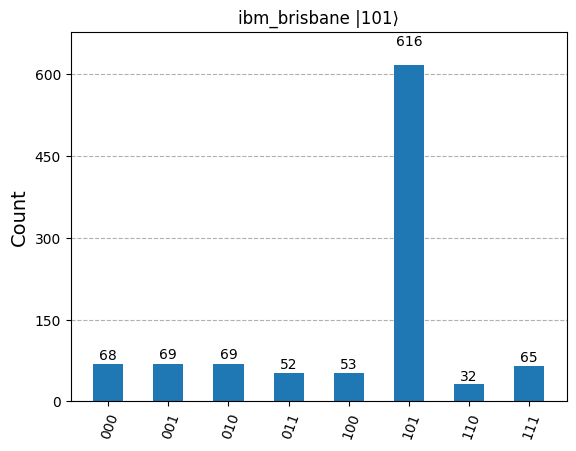


Running Grover for |110⟩ on ibm_brisbane…


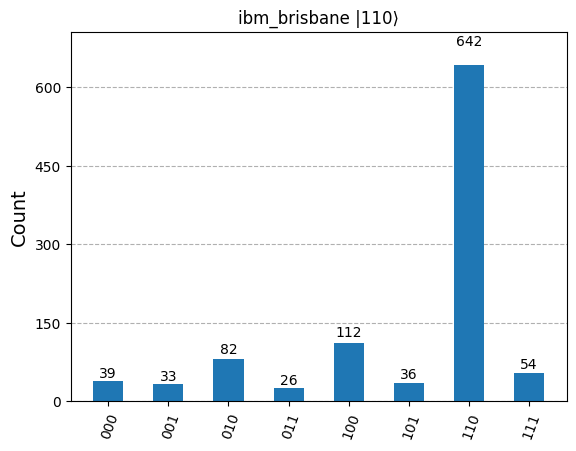


Running Grover for |111⟩ on ibm_brisbane…


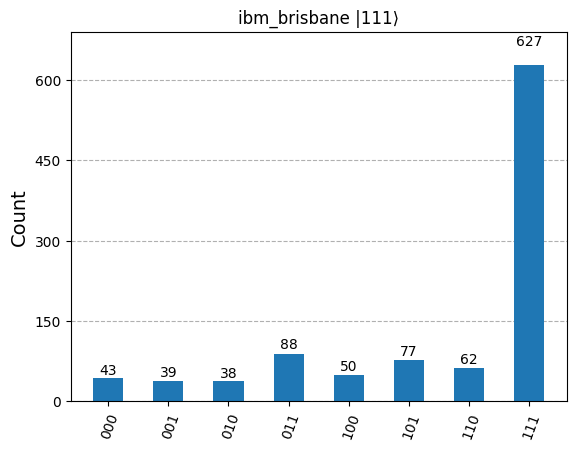

In [12]:
for state, qc_isa in hw_circuits:
        print(f"\nRunning Grover for |{state}⟩ on {backend.name}…")
        job    = sampler.run([qc_isa]).result()  # ← submit a list of one circuit
        # job is a list of length 1; extract the first PubResult
        pubres = job[0]

        # 4) Pull counts from the classical register
        #    In your Grover circuits you used QuantumCircuit(n, n),
        #    so the ClassicalRegister is named 'c' by default.
        counts = pubres.join_data().get_counts()
        display(plot_histogram(counts, title=f"{backend.name} |{state}⟩"))

In [13]:
# 4) At the very end, assemble a DataFrame and display
df_metrics = pd.DataFrame.from_dict(metrics, orient='index')
df_metrics.index.name = 'raw_state'
df_metrics = df_metrics.reset_index()
display(df_metrics)

,raw_state,gate_count_raw,cx_count_raw,depth_raw,gate_count_isa,cx_count_isa,depth_isa,counts_hw
0,000,8,0,4,243,0,165,"{'111': 57, '010': 69, '001': 75, '100': 95, '..."
1,001,8,0,4,245,0,168,"{'100': 53, '001': 606, '110': 31, '011': 81, ..."
2,010,8,0,4,248,0,168,"{'010': 610, '110': 70, '001': 47, '011': 55, ..."
3,011,8,0,4,247,0,166,"{'111': 72, '010': 96, '011': 587, '001': 68, ..."
4,100,8,0,4,241,0,164,"{'010': 43, '100': 623, '011': 44, '000': 81, ..."
5,101,8,0,4,277,0,170,"{'111': 85, '101': 616, '100': 67, '011': 53, ..."
6,110,8,0,4,246,0,165,"{'101': 39, '110': 648, '111': 51, '011': 39, ..."
7,111,8,0,4,245,0,166,"{'110': 66, '111': 638, '101': 69, '011': 89, ..."


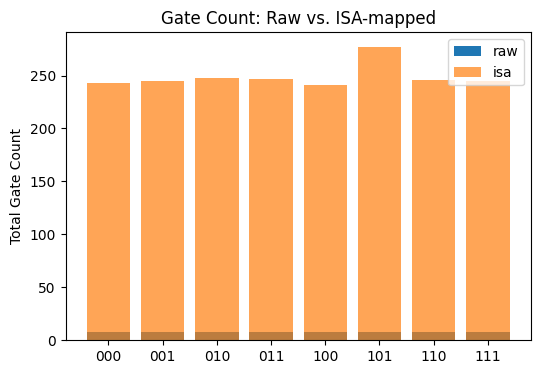

In [14]:
# Optionally, plot a quick bar chart of raw vs. ISA gate counts
plt.figure(figsize=(6,4))
plt.bar(df_metrics['raw_state'], df_metrics['gate_count_raw'], label='raw')
plt.bar(df_metrics['raw_state'], df_metrics['gate_count_isa'], label='isa', alpha=0.7)
plt.ylabel('Total Gate Count')
plt.title('Gate Count: Raw vs. ISA-mapped')
plt.legend()
plt.show()

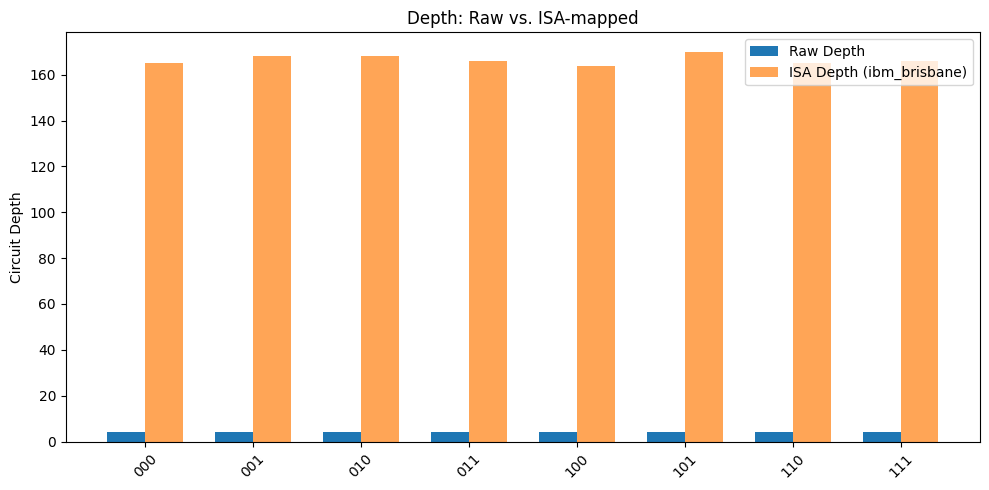

In [ ]:
if 'depth_isa' in df_metrics:
    plt.figure(figsize=(10,5))
    bar_w = 0.35
    idx   = range(len(df_metrics))
    plt.bar([i-bar_w/2 for i in idx],
            df_metrics['depth_raw'], bar_w, label='Raw Depth')
    plt.bar([i+bar_w/2 for i in idx],
            df_metrics['depth_isa'], bar_w, label=f'ISA Depth ({backend.name})', alpha=0.7)

    plt.xticks(idx, df_metrics['raw_state'], rotation=45) 

    plt.ylabel('Circuit Depth')
    plt.title('Depth: Raw vs. ISA-mapped')
    plt.legend(); plt.tight_layout(); plt.show()